## Imports

In [4]:
import os
import sys
sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

np.random.seed(1234)
plt.style.use('default')

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Fold 1

## Prepare Reference Alleles

In [9]:
cluster = '13'
fold = '1'
peak = 'overlap'
gwas = 'Kunkle'
gwas_bed = pd.read_csv('/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.txt', header=None, sep='\t')
gwas_chrom = gwas_bed[0].tolist()
gwas_start = gwas_bed[1].tolist()
gwas_end = gwas_bed[2].tolist()
gwas_rsid = gwas_bed[3].tolist()
gwas_locus = gwas_bed[5].to_list()
gwas_major = gwas_bed[6].tolist()
gwas_minor = gwas_bed[7].tolist()

major_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.major.fasta'
major_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_major_hyp_scores.txt'

major_seqs = [x.rstrip() for (i,x) in enumerate(open(major_fasta)) if i%2==1]
major_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in major_seqs if ('N' not in x)]

print("Num onehot sequences:", len(major_onehot))

major_hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(major_hyp_file)], major_seqs) if 'N' not in w[1]]

major_imp_scores = get_impscores(major_hyp_scores, major_onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(major_imp_scores,
                                 major_onehot,
                                 major_hyp_scores)])) == 0

major_normed_imp_scores, major_normed_hyp_scores = normalize_scores(
    impscores=major_imp_scores, hyp_impscores=major_hyp_scores, onehot_data=major_onehot)

Num onehot sequences: 40


## Prepare Alternate Alleles

In [10]:
minor_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.minor.fasta'
minor_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_minor_hyp_scores.txt'
                                                                                
minor_seqs = [x.rstrip() for (i,x) in enumerate(open(minor_fasta)) if i%2==1]       
minor_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in minor_seqs if ('N' not in x)]
                                                                                
print("Num onehot sequences:", len(minor_onehot))                                 
                                                                                
minor_hyp_scores = [w[0] for w in zip([                                           
    np.array([[float(z) for z in y.split(",")]                                  
                for y in x.rstrip().split("\t")[2].split(";")])                 
    for x in open(minor_hyp_file)], minor_seqs) if 'N' not in w[1]]                 
                                                                                
minor_imp_scores = get_impscores(minor_hyp_scores, minor_onehot)                      
                                                                                
assert (np.max([np.max(np.abs(z*y - x))                                         
                for x,y,z in zip(minor_imp_scores,                                
                                 minor_onehot,                                    
                                 minor_hyp_scores)])) == 0                        
                                                                                
minor_normed_imp_scores, minor_normed_hyp_scores = normalize_scores(                
    impscores=minor_imp_scores, hyp_impscores=minor_hyp_scores, onehot_data=minor_onehot)

Num onehot sequences: 40


## Find Alternate Alleles that Break Accessibility

In [11]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'rsid': [], 'locus':[], 'major_allele':[], 'minor_allele':[], 'major_score':[], 'minor_score':[], 'delta':[]}

for i,j in enumerate(gwas_chrom):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(gwas_chrom[i])
    seq_dict['start'].append(gwas_start[i])
    seq_dict['end'].append(gwas_end[i])
    seq_dict['rsid'].append(gwas_rsid[i])
    seq_dict['locus'].append(gwas_locus[i])
    seq_dict['major_allele'].append(gwas_major[i])
    seq_dict['minor_allele'].append(gwas_minor[i])
    seq_dict['major_score'].append(np.sum(major_imp_scores[i][400:600]))
    seq_dict['minor_score'].append(np.sum(minor_imp_scores[i][400:600]))
    seq_dict['delta'].append(np.sum(minor_imp_scores[i][400:600]) - np.sum(major_imp_scores[i][400:600]))
    
seq_df = pd.DataFrame.from_dict(seq_dict)
seq_df.sort_values(by='delta', ascending=True, inplace=True)
seq_df.head(10)

index    chr     start       end         rsid  locus major_allele  \
12     12  chr19  45349401  45349402    rs3810143    156            T   
11     11  chr19  45349401  45349402    rs3810143    156            T   
14     14  chr19  45394335  45394336   rs71352238    156            T   
13     13  chr19  45393515  45393516  rs117310449    156            C   
31     31  chr19  45601600  45601601  rs138137383    156            G   
4       4  chr19  45221766  45221767   rs79638902    156            C   
10     10  chr19  45349368  45349369    rs2927472    156            C   
19     19  chr19  45447160  45447161       rs5157    156            C   
21     21  chr19  45454685  45454686    rs7248162    156            C   
26     26  chr19  45458211  45458212  rs117316645    156            G   

   minor_allele  major_score  minor_score     delta  
12            G     2.523553     1.959167 -0.564386  
11            C     2.523553     2.014447 -0.509106  
14            C     2.896446     2.476566 -0.419881  
13            T    -0.033794    -0.318184 -0.284390  
31            A     0.017807    -0.233076 -0.250883  
4             T     0.566039     0.316724 -0.249315  
10            T     2.463817     2.297085 -0.166732  
19            T     0.284019     0.131686 -0.152333  
21            T     0.898200     0.755729 -0.142471  
26            C     0.938058     0.806777 -0.131281

## Get 10 bp around SNP

In [12]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(major_seqs[idx][490:510])
    print(major_seqs[idx][490:500], '|', major_seqs[idx][500:510])

AGAATTCTTTGGCAGGGGCG
AGAATTCTTTGGCAGGGGCG
CGCCGTGGCTACCCTGCGAG
GGCCAGAGGCAGAGTGATGA
CTGAGGCTCGGCTGGTCTCC


## Visualize Top Sequences

Index:  12  Importance:  2.5235528608399997  RSID:  rs3810143   chr19 : 45349401 - 45349402  Locus:  156
Major Allele:  T


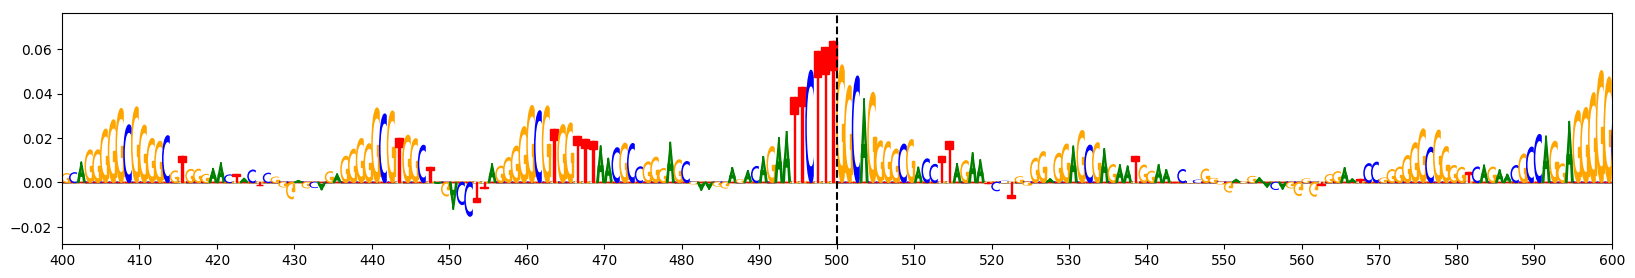

Index:  12  Importance:  1.95916709981  RSID:  rs3810143
Minor Allele:  G


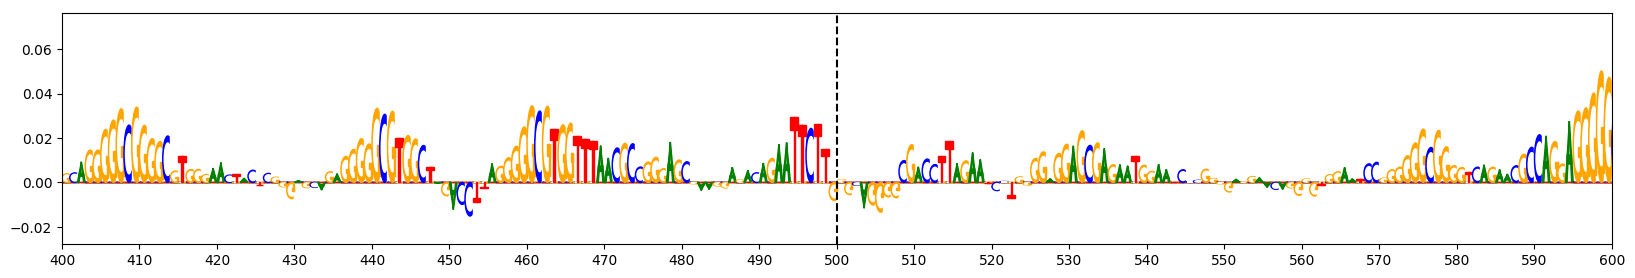

Index:  12  Delta:  -0.5643857610299998  RSID:  rs3810143
Minor - Major:  G - T


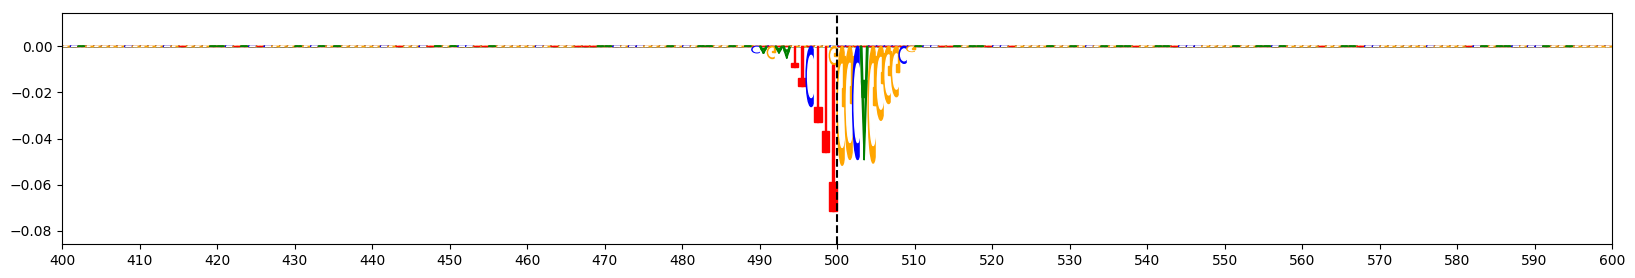

Index:  11  Importance:  2.5235528608399997  RSID:  rs3810143   chr19 : 45349401 - 45349402  Locus:  156
Major Allele:  T


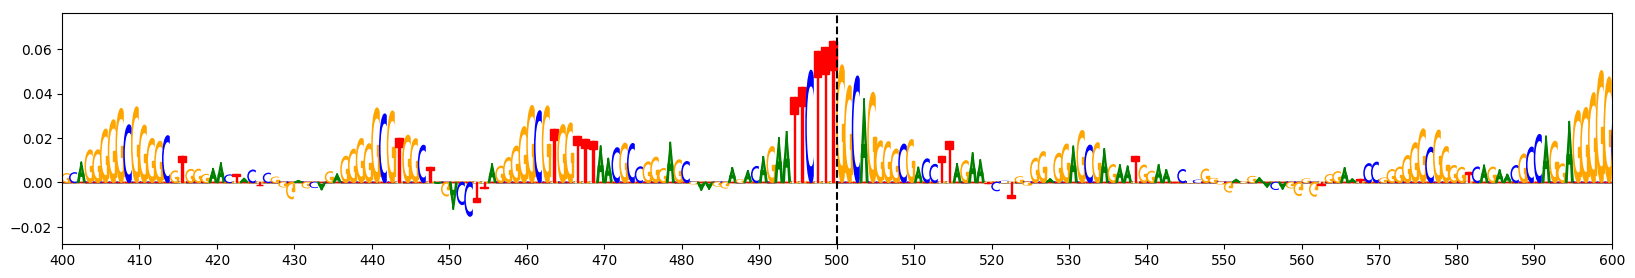

Index:  11  Importance:  2.01444676064  RSID:  rs3810143
Minor Allele:  C


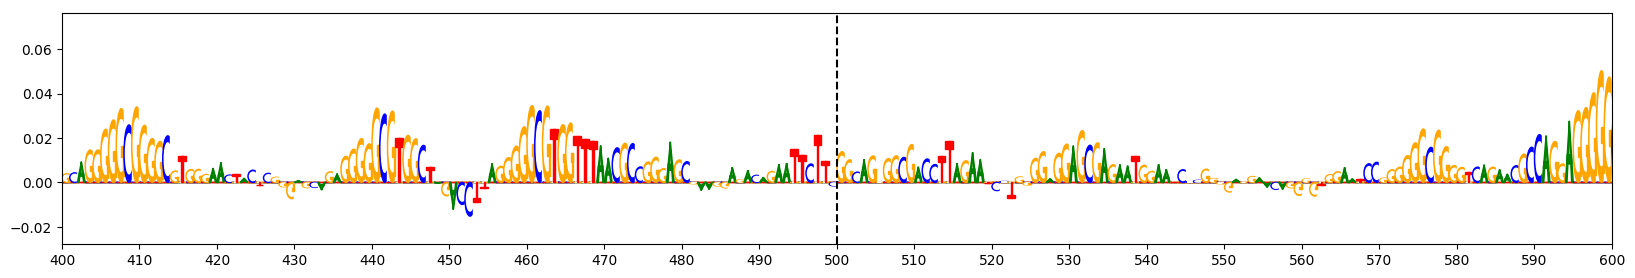

Index:  11  Delta:  -0.5091061001999999  RSID:  rs3810143
Minor - Major:  C - T


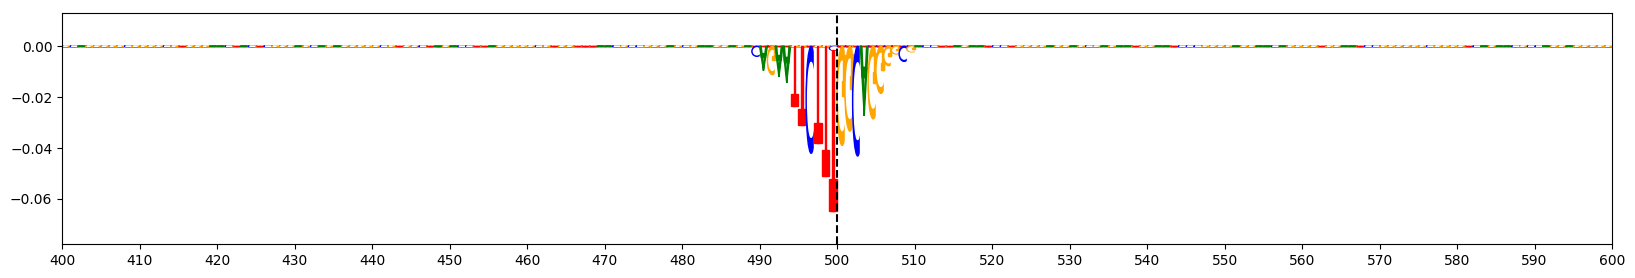

Index:  14  Importance:  2.8964462813  RSID:  rs71352238   chr19 : 45394335 - 45394336  Locus:  156
Major Allele:  T


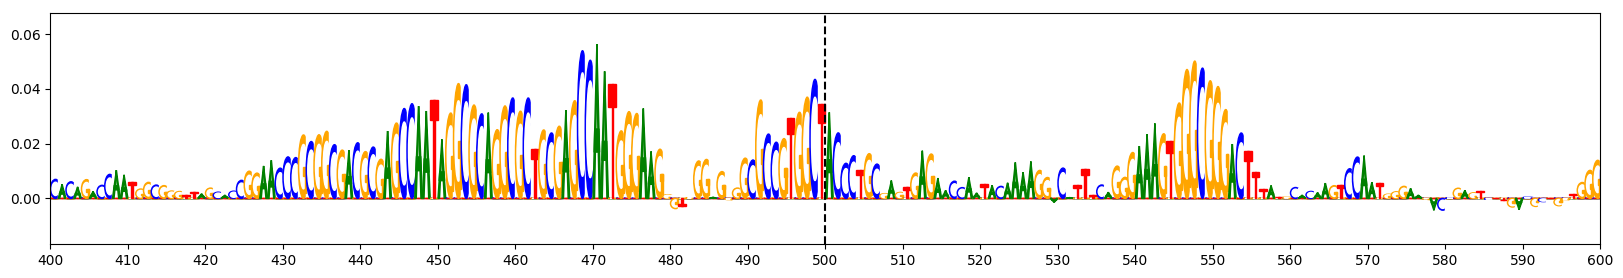

Index:  14  Importance:  2.4765655198000003  RSID:  rs71352238
Minor Allele:  C


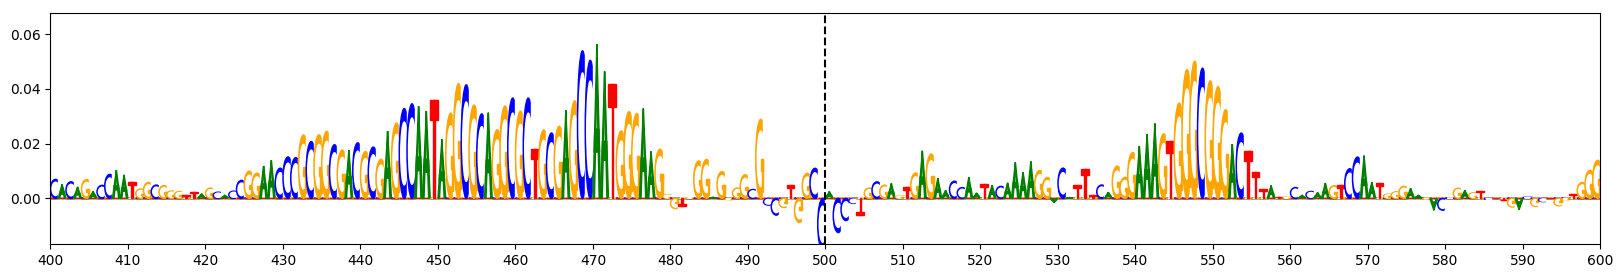

Index:  14  Delta:  -0.41988076149999953  RSID:  rs71352238
Minor - Major:  C - T


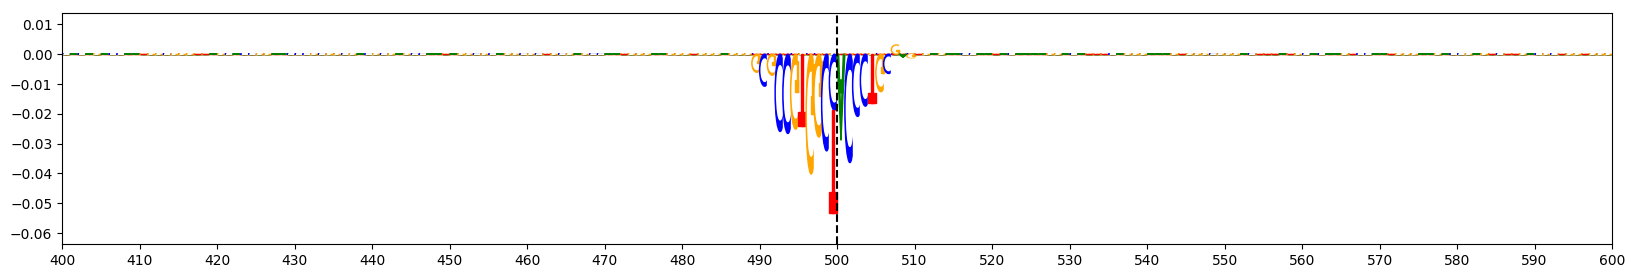

Index:  13  Importance:  -0.03379397799999995  RSID:  rs117310449   chr19 : 45393515 - 45393516  Locus:  156
Major Allele:  C


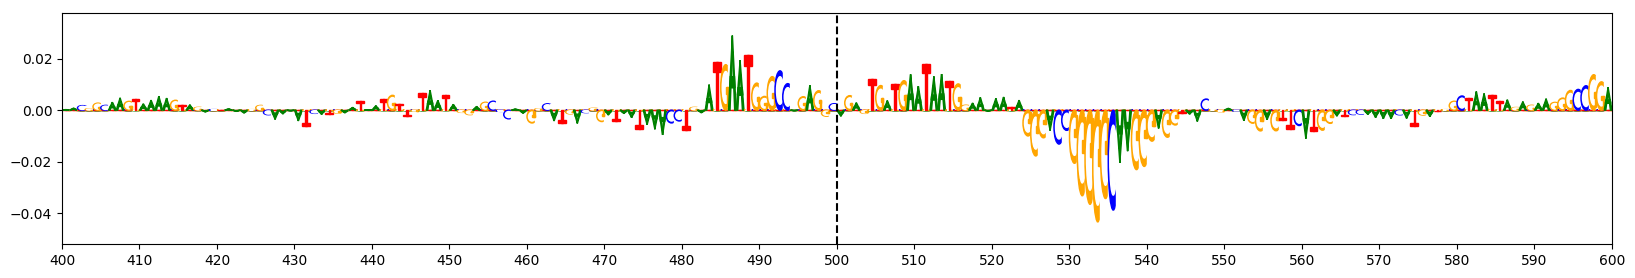

Index:  13  Importance:  -0.31818376930000003  RSID:  rs117310449
Minor Allele:  T


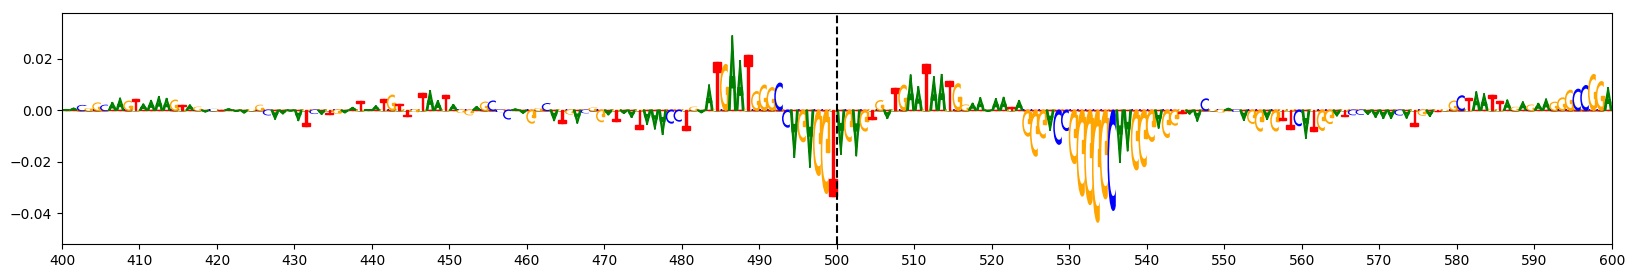

Index:  13  Delta:  -0.2843897913000001  RSID:  rs117310449
Minor - Major:  T - C


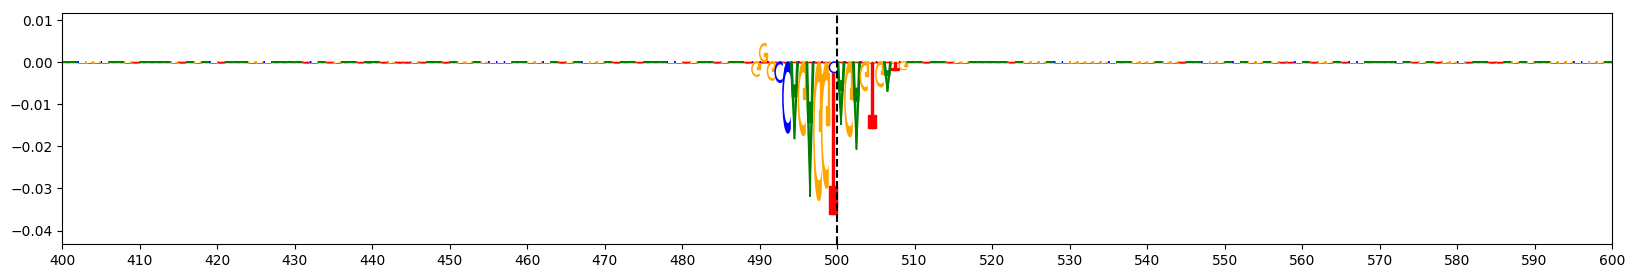

Index:  31  Importance:  0.01780692040000001  RSID:  rs138137383   chr19 : 45601600 - 45601601  Locus:  156
Major Allele:  G


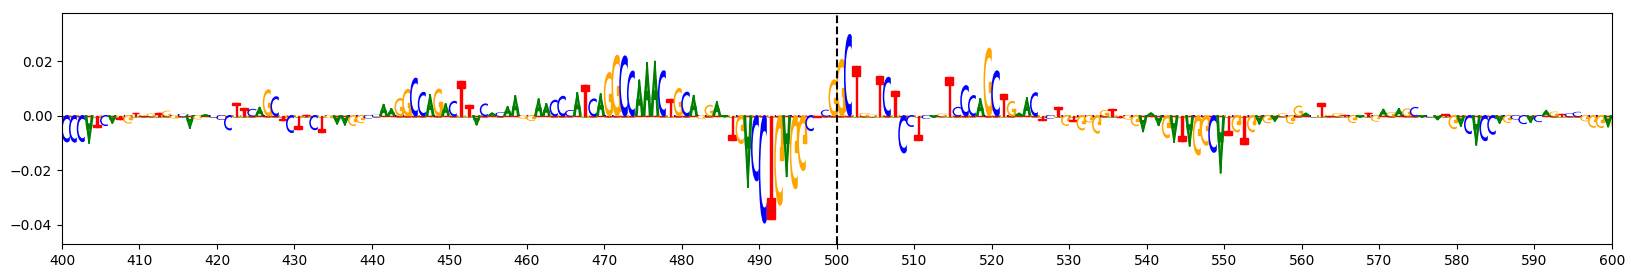

Index:  31  Importance:  -0.2330759515  RSID:  rs138137383
Minor Allele:  A


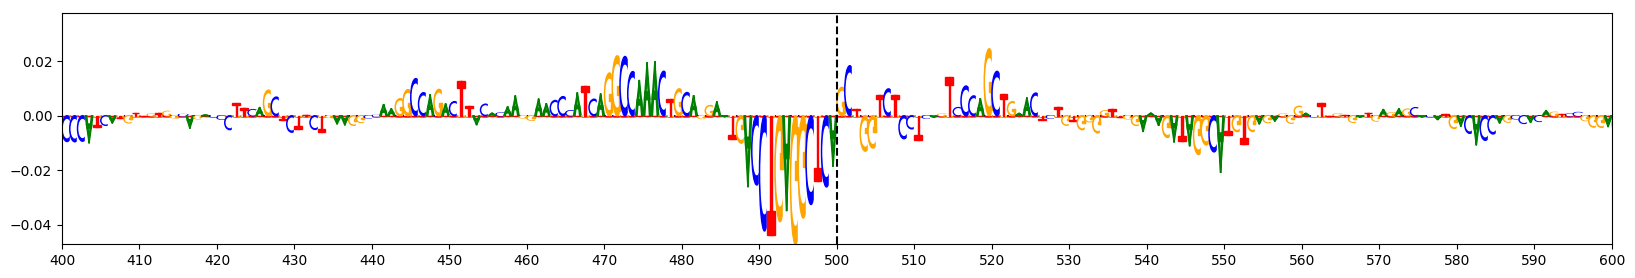

Index:  31  Delta:  -0.2508828719  RSID:  rs138137383
Minor - Major:  A - G


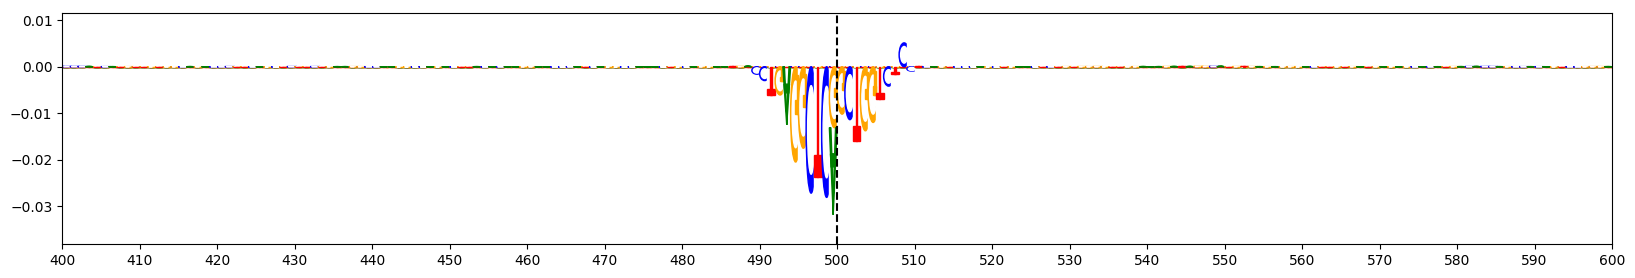

In [14]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx], 
          ' ', seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'], " Locus: ", seq_df.at[idx, 'locus'])
    print("Major Allele: ", gwas_major[idx])
    ylim = plot_weights(major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx])
    print("Minor Allele: ", gwas_minor[idx])
    a = plot_weights(minor_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

## Find Alternate Alleles that Improve Accessibility

In [15]:
seq_df.sort_values(by='delta', ascending=False, inplace=True)
seq_df.head(10)

index    chr      start        end         rsid  locus major_allele  \
1       1  chr19    1040045    1040046    rs3764642    154            G   
29     29  chr19   45504526   45504527  rs117612135    156            C   
0       0  chr19    1040045    1040046    rs3764642    154            G   
7       7  chr19   45348252   45348253   rs10426423    156            C   
3       3  chr19   45147339   45147340   rs11540084    156            G   
15     15  chr19   45408835   45408836     rs405509    156            G   
34     34   chr2  127841768  127841769   rs10200967    157            T   
33     33  chr19   45601600   45601601  rs138137383    156            G   
8       8  chr19   45348252   45348253   rs10426423    156            C   
2       2  chr19   18539743   18539744   rs34746918    155            C   

   minor_allele  major_score  minor_score     delta  
1             C     1.104364     1.485232  0.380867  
29            T     2.400851     2.676086  0.275235  
0             A     1.104364     1.367502  0.263138  
7             A     1.321346     1.495740  0.174394  
3             T     1.084010     1.230861  0.146851  
15            T    -0.488068    -0.369254  0.118814  
34            C     0.938761     1.055346  0.116584  
33            T     0.017807     0.122886  0.105079  
8             G     1.321346     1.409967  0.088621  
2             T     0.232654     0.320226  0.087572

## Get 10 bp around SNP

In [16]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(minor_seqs[idx][490:510])
    print(minor_seqs[idx][490:500], '|', major_seqs[idx][500:510])

GACGGGCAGGTCGCCCAATA
CCTGCCCAACCCCTCCTGAG
GACGGGCAGGTCGCCCAATA
aggggaggaccagggcgcgc
AGAGCGAGCGGGCGCCGGGA


## Visualize Top Sequences

Index:  1  Importance:  1.1043642768000002  RSID:  rs3764642 chr19 :  1040045  -  1040046  Locus:  154
Minor Allele:  C


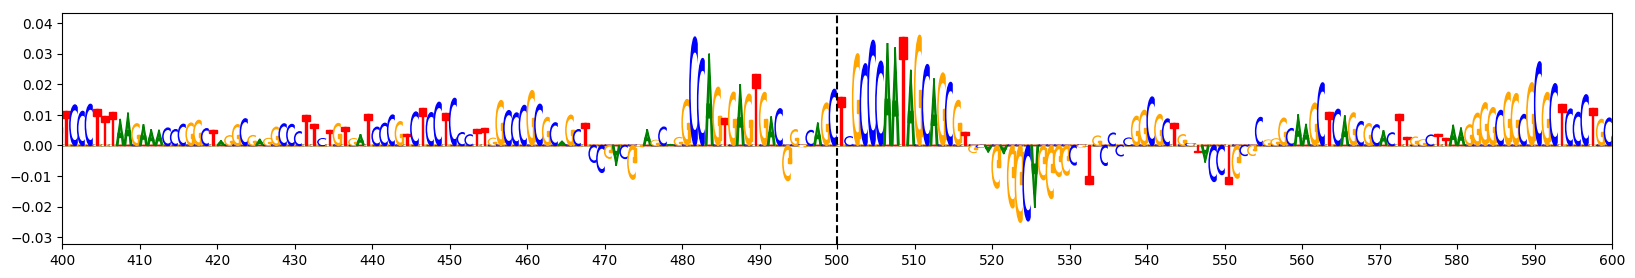

Index:  1  Importance:  1.1043642768000002  RSID:  rs3764642
Major Allele:  G


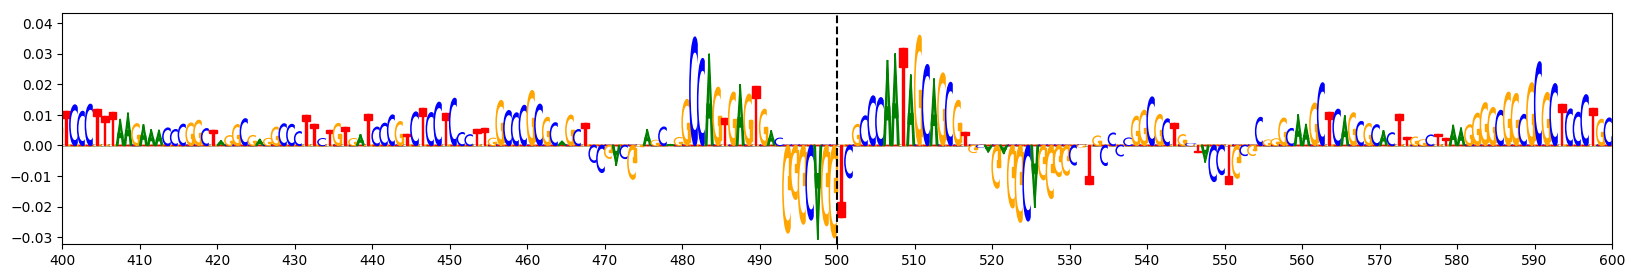

Index:  1  Delta:  0.38086748319999986  RSID:  rs3764642
Minor - Major:  C - G


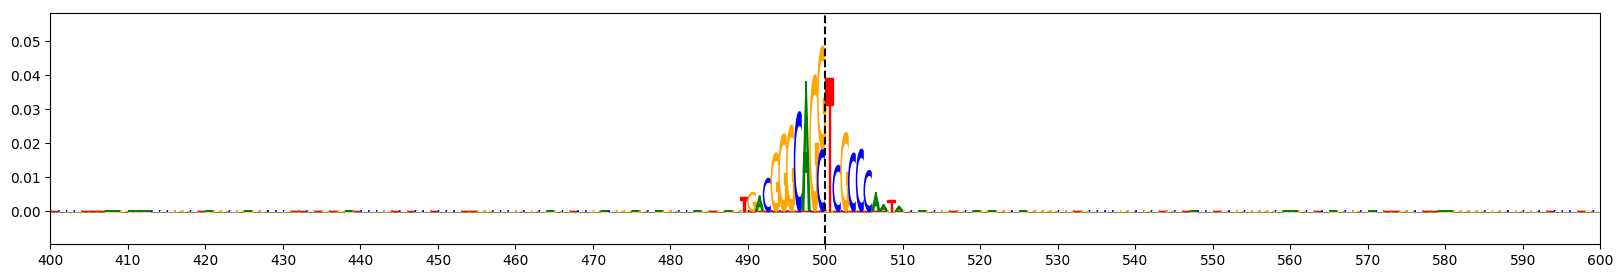

Index:  29  Importance:  2.4008510650000003  RSID:  rs117612135 chr19 :  45504526  -  45504527  Locus:  156
Minor Allele:  T


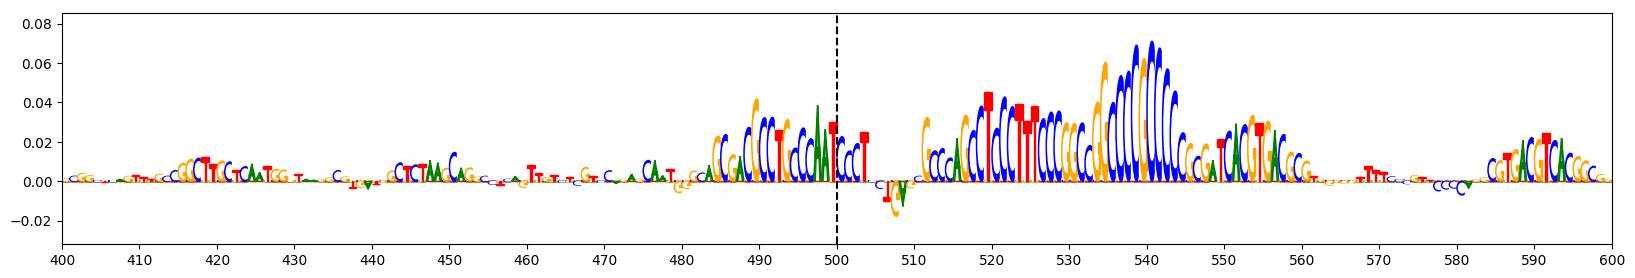

Index:  29  Importance:  2.4008510650000003  RSID:  rs117612135
Major Allele:  C


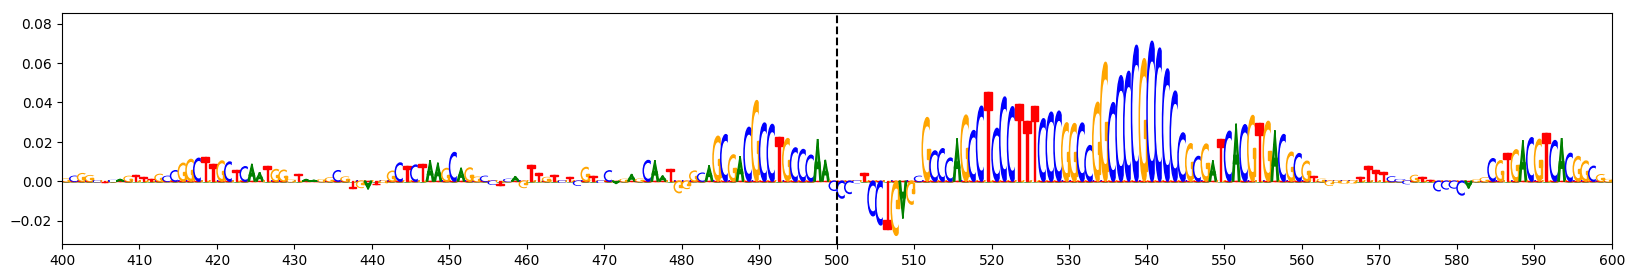

Index:  29  Delta:  0.27523459314  RSID:  rs117612135
Minor - Major:  T - C


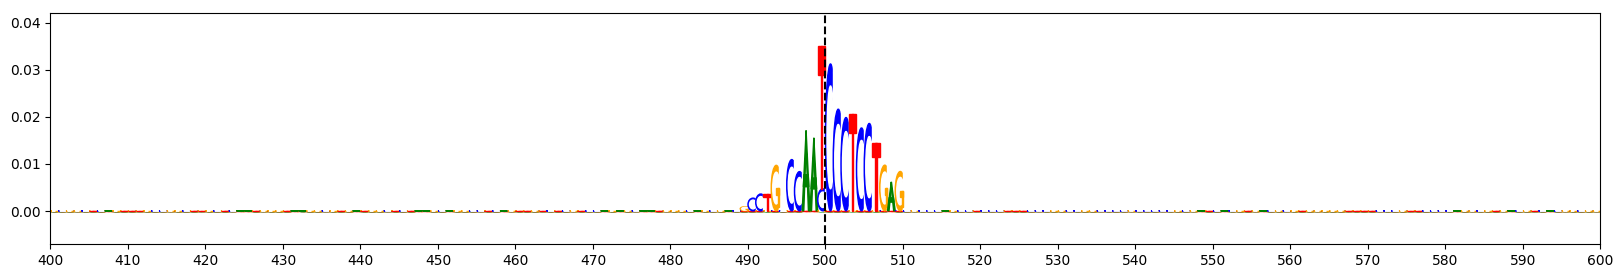

Index:  0  Importance:  1.1043642768000002  RSID:  rs3764642 chr19 :  1040045  -  1040046  Locus:  154
Minor Allele:  A


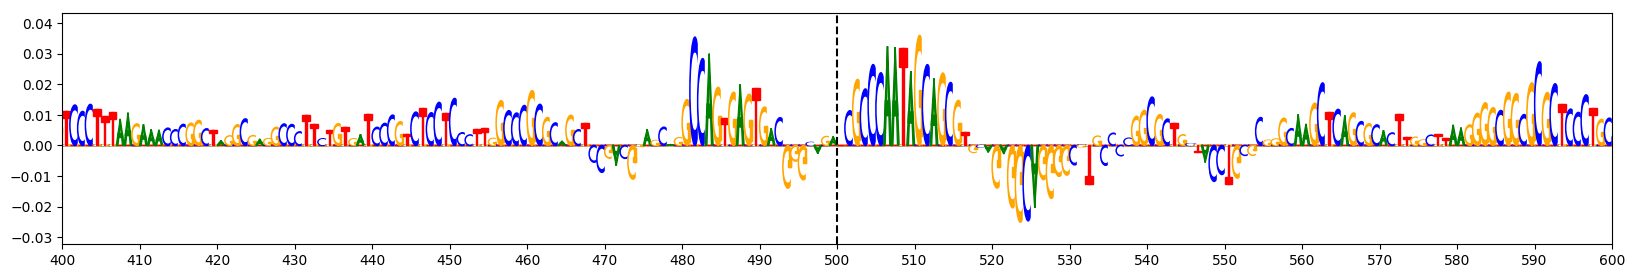

Index:  0  Importance:  1.1043642768000002  RSID:  rs3764642
Major Allele:  G


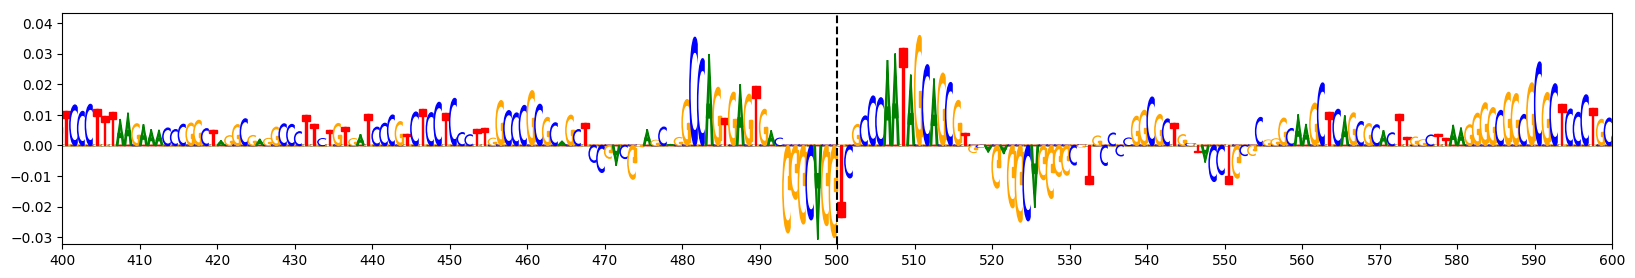

Index:  0  Delta:  0.26313800619999994  RSID:  rs3764642
Minor - Major:  A - G


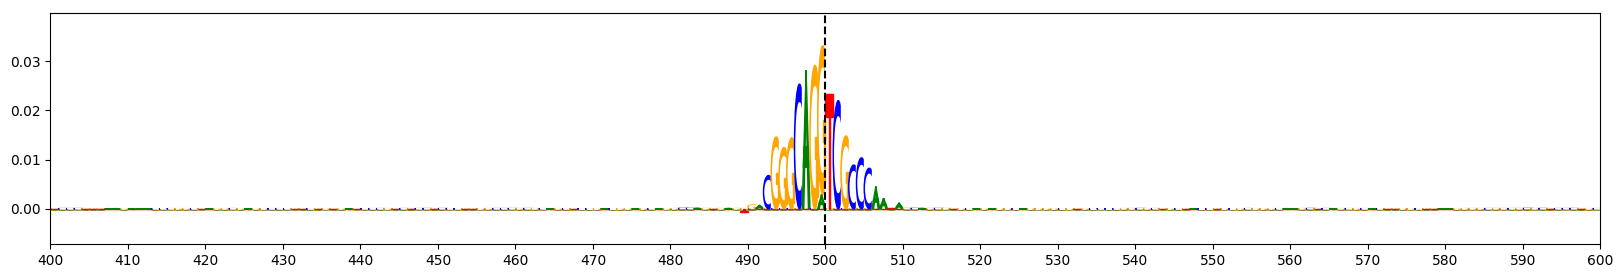

Index:  7  Importance:  1.3213461133999997  RSID:  rs10426423 chr19 :  45348252  -  45348253  Locus:  156
Minor Allele:  A


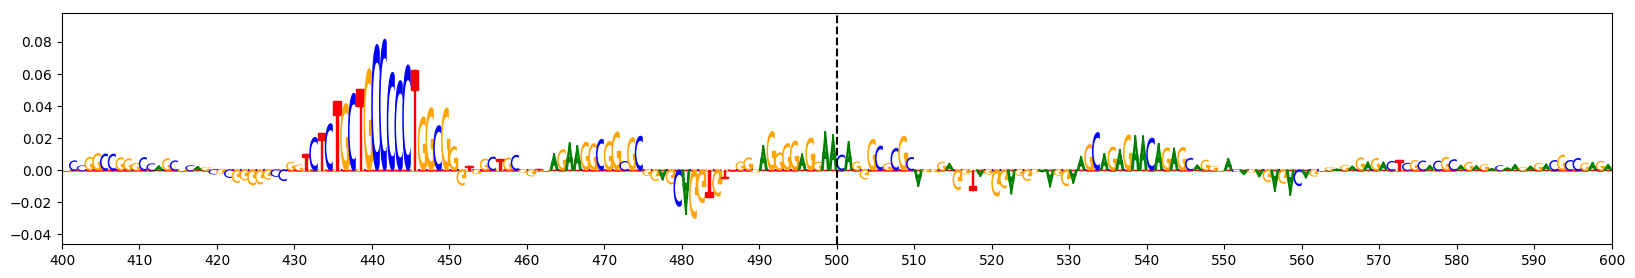

Index:  7  Importance:  1.3213461133999997  RSID:  rs10426423
Major Allele:  C


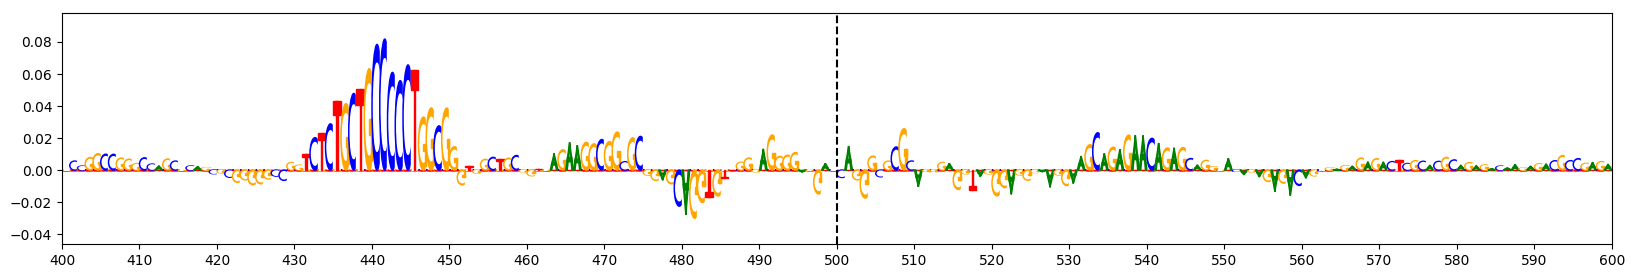

Index:  7  Delta:  0.1743935348000003  RSID:  rs10426423
Minor - Major:  A - C


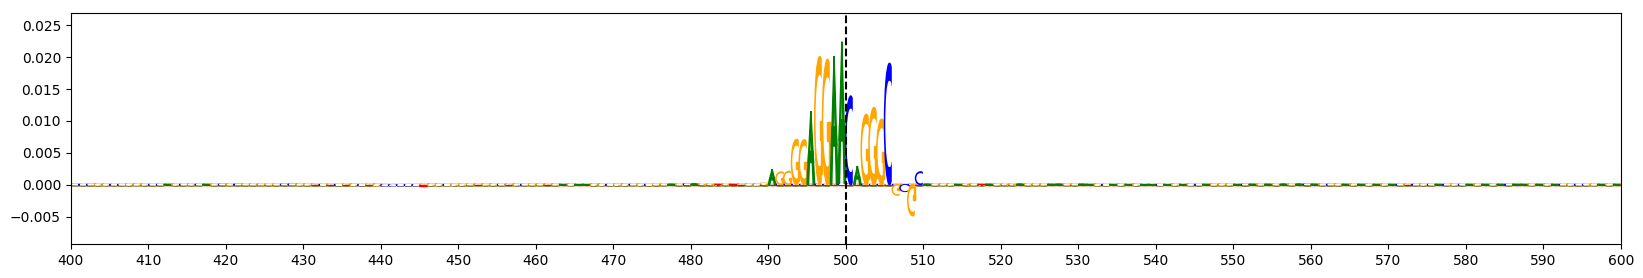

Index:  3  Importance:  1.0840097526999999  RSID:  rs11540084 chr19 :  45147339  -  45147340  Locus:  156
Minor Allele:  T


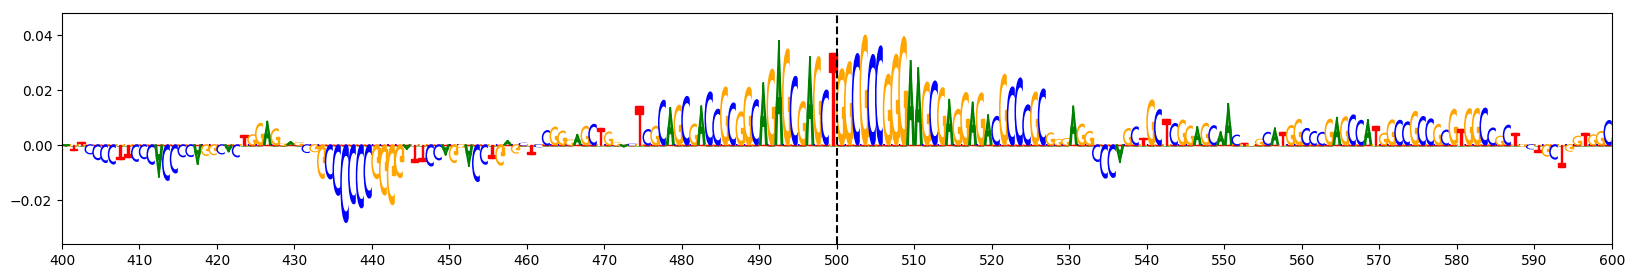

Index:  3  Importance:  1.0840097526999999  RSID:  rs11540084
Major Allele:  G


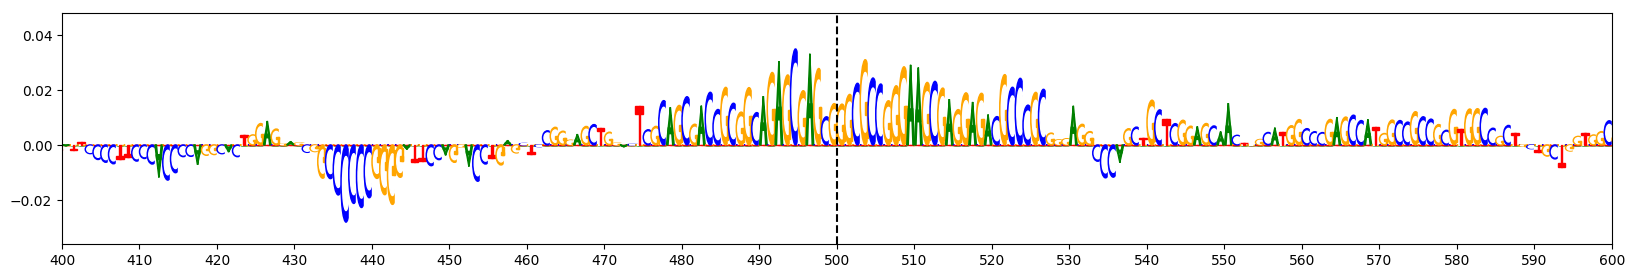

Index:  3  Delta:  0.1468508044000001  RSID:  rs11540084
Minor - Major:  T - G


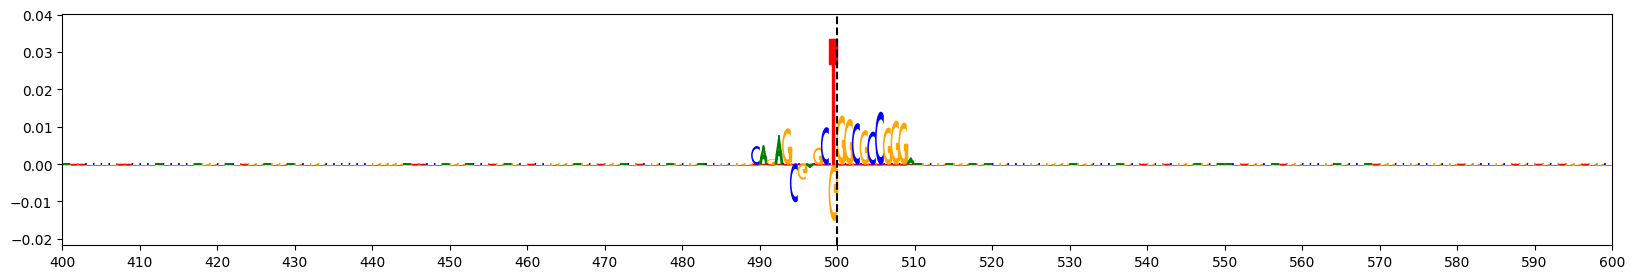

In [17]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx], 
          seq_df.at[idx, 'chr'], ': ', seq_df.at[idx, 'start'], ' - ', seq_df.at[idx, 'end'], " Locus: ", seq_df.at[idx, 'locus'])
    print("Minor Allele: ", gwas_minor[idx])
    ylim = plot_weights(minor_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx])
    print("Major Allele: ", gwas_major[idx])
    a = plot_weights(major_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

# Fold 7

## Prepare Reference Alleles

In [18]:
cluster = '13'
fold = '7'
peak = 'overlap'
gwas = 'Kunkle'
gwas_bed = pd.read_csv('/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.txt', header=None, sep='\t')
gwas_chrom = gwas_bed[0].tolist()
gwas_start = gwas_bed[1].tolist()
gwas_end = gwas_bed[2].tolist()
gwas_rsid = gwas_bed[3].tolist()
gwas_locus = gwas_bed[5].to_list()
gwas_major = gwas_bed[6].tolist()
gwas_minor = gwas_bed[7].tolist()

major_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.major.fasta'
major_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_major_hyp_scores.txt'

major_seqs = [x.rstrip() for (i,x) in enumerate(open(major_fasta)) if i%2==1]
major_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in major_seqs if ('N' not in x)]

print("Num onehot sequences:", len(major_onehot))

major_hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(major_hyp_file)], major_seqs) if 'N' not in w[1]]

major_imp_scores = get_impscores(major_hyp_scores, major_onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(major_imp_scores,
                                 major_onehot,
                                 major_hyp_scores)])) == 0

major_normed_imp_scores, major_normed_hyp_scores = normalize_scores(
    impscores=major_imp_scores, hyp_impscores=major_hyp_scores, onehot_data=major_onehot)

Num onehot sequences: 14


## Prepare Alternate Alleles

In [19]:
minor_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.minor.fasta'
minor_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_minor_hyp_scores.txt'
                                                                                
minor_seqs = [x.rstrip() for (i,x) in enumerate(open(minor_fasta)) if i%2==1]       
minor_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in minor_seqs if ('N' not in x)]
                                                                                
print("Num onehot sequences:", len(minor_onehot))                                 
                                                                                
minor_hyp_scores = [w[0] for w in zip([                                           
    np.array([[float(z) for z in y.split(",")]                                  
                for y in x.rstrip().split("\t")[2].split(";")])                 
    for x in open(minor_hyp_file)], minor_seqs) if 'N' not in w[1]]                 
                                                                                
minor_imp_scores = get_impscores(minor_hyp_scores, minor_onehot)                      
                                                                                
assert (np.max([np.max(np.abs(z*y - x))                                         
                for x,y,z in zip(minor_imp_scores,                                
                                 minor_onehot,                                    
                                 minor_hyp_scores)])) == 0                        
                                                                                
minor_normed_imp_scores, minor_normed_hyp_scores = normalize_scores(                
    impscores=minor_imp_scores, hyp_impscores=minor_hyp_scores, onehot_data=minor_onehot)

Num onehot sequences: 14


## Find Alternate Alleles that Break Accessibility

In [20]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'rsid': [], 'locus':[], 'major_allele':[], 'minor_allele':[], 'major_score':[], 'minor_score':[], 'delta':[]}

for i,j in enumerate(gwas_chrom):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(gwas_chrom[i])
    seq_dict['start'].append(gwas_start[i])
    seq_dict['end'].append(gwas_end[i])
    seq_dict['rsid'].append(gwas_rsid[i])
    seq_dict['locus'].append(gwas_locus[i])
    seq_dict['major_allele'].append(gwas_major[i])
    seq_dict['minor_allele'].append(gwas_minor[i])
    seq_dict['major_score'].append(np.sum(major_imp_scores[i][400:600]))
    seq_dict['minor_score'].append(np.sum(minor_imp_scores[i][400:600]))
    seq_dict['delta'].append(np.sum(minor_imp_scores[i][400:600]) - np.sum(major_imp_scores[i][400:600]))
    
seq_df = pd.DataFrame.from_dict(seq_dict)
seq_df.sort_values(by='delta', ascending=True, inplace=True)
seq_df.head(10)

index    chr     start       end        rsid  locus major_allele  \
0       0  chr11  47276674  47276675  rs11039149    148            A   
1       1  chr11  47377282  47377283  rs71475909    148            A   
13     13  chr11  85830156  85830157    rs567075    150            C   
9       9  chr11  85779296  85779297   rs2509608    150            G   
6       6  chr11  47448496  47448497  rs11600581    148            T   
5       5  chr11  47430457  47430458   rs7937331    148            C   
10     10  chr11  85779296  85779297   rs2509608    150            G   
4       4  chr11  47429903  47429904   rs7947450    148            G   
7       7  chr11  47448496  47448497  rs11600581    148            T   
2       2  chr11  47377282  47377283  rs71475909    148            A   

   minor_allele  major_score  minor_score     delta  
0             G     0.397385     0.043404 -0.353981  
1             C     0.082805    -0.044251 -0.127056  
13            T     0.874456     0.829603 -0.044852  
9             T     0.653526     0.622926 -0.030600  
6             A     0.166461     0.163339 -0.003123  
5             T     0.303433     0.300390 -0.003043  
10            C     0.653526     0.655411  0.001886  
4             A     2.181930     2.185450  0.003521  
7             C     0.166461     0.173844  0.007383  
2             G     0.082805     0.095905  0.013100

## Get 10 bp around SNP

In [21]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(major_seqs[idx][490:510])
    print(major_seqs[idx][490:500], '|', major_seqs[idx][500:510])

CTCCCCTGTAGCCCACCAGC
tgcttgcgcacacacaggcg
CTTTGCTTATCCGTGTTGAT
AATGGGGCTTGGAGACGCTC
agaactcaattgaccatcag


## Visualize Top Sequences

Index:  0  Importance:  0.3973850361  RSID:  rs11039149   chr11 : 47276674 - 47276675  Locus:  148
Major Allele:  A


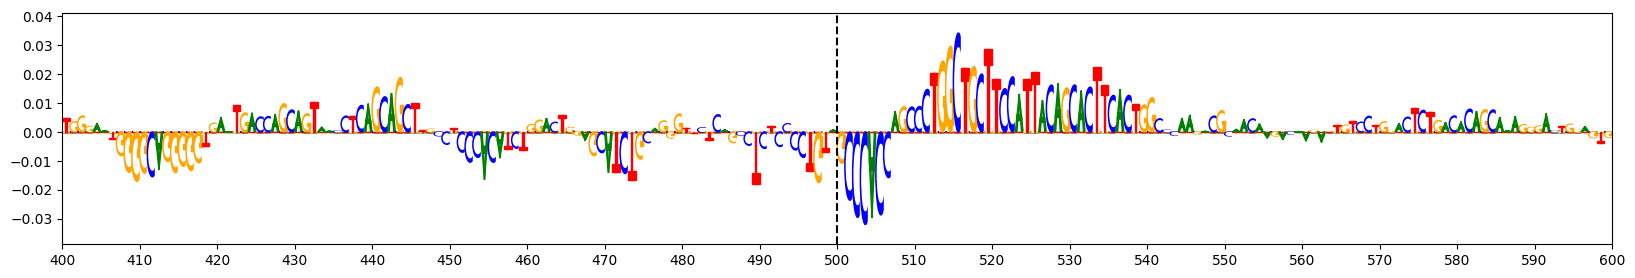

Index:  0  Importance:  0.04340436319999996  RSID:  rs11039149
Minor Allele:  G


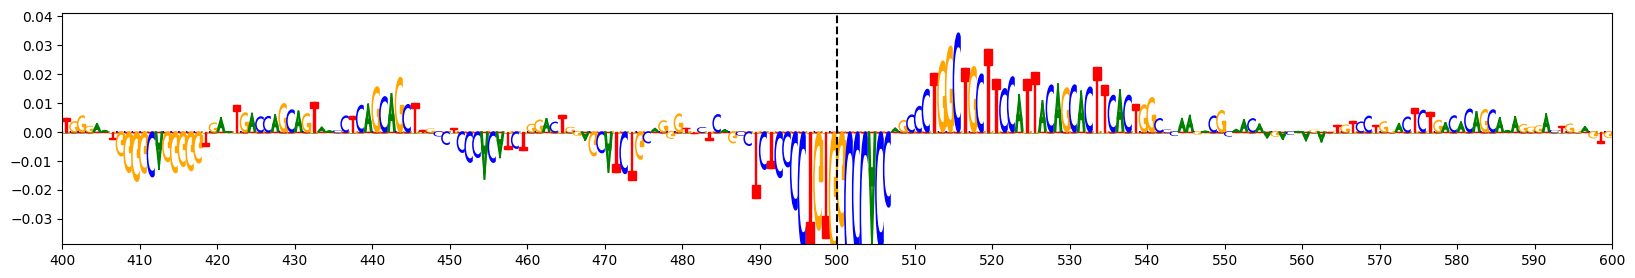

Index:  0  Delta:  -0.3539806729  RSID:  rs11039149
Minor - Major:  G - A


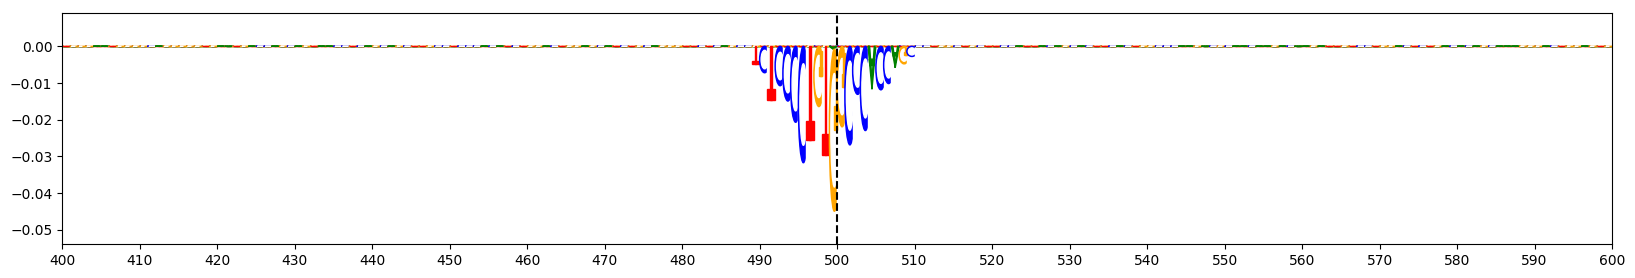

Index:  1  Importance:  0.0828051179  RSID:  rs71475909   chr11 : 47377282 - 47377283  Locus:  148
Major Allele:  A


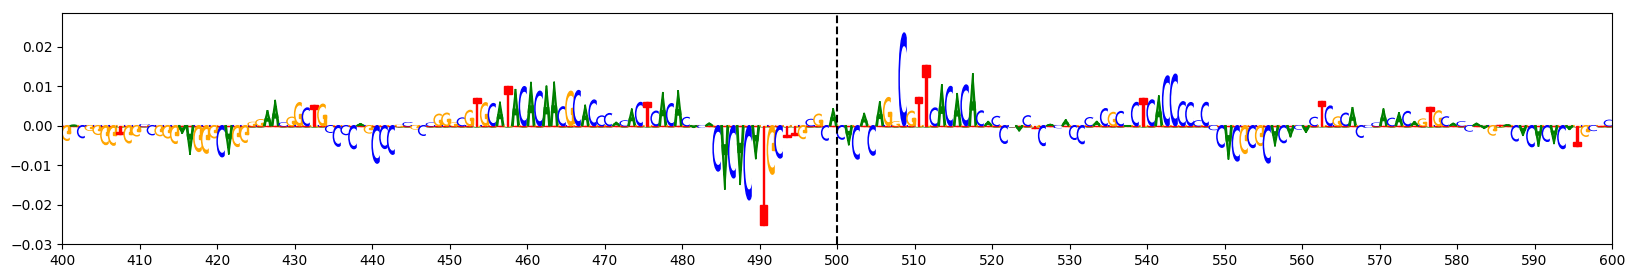

Index:  1  Importance:  -0.044251145600000014  RSID:  rs71475909
Minor Allele:  C


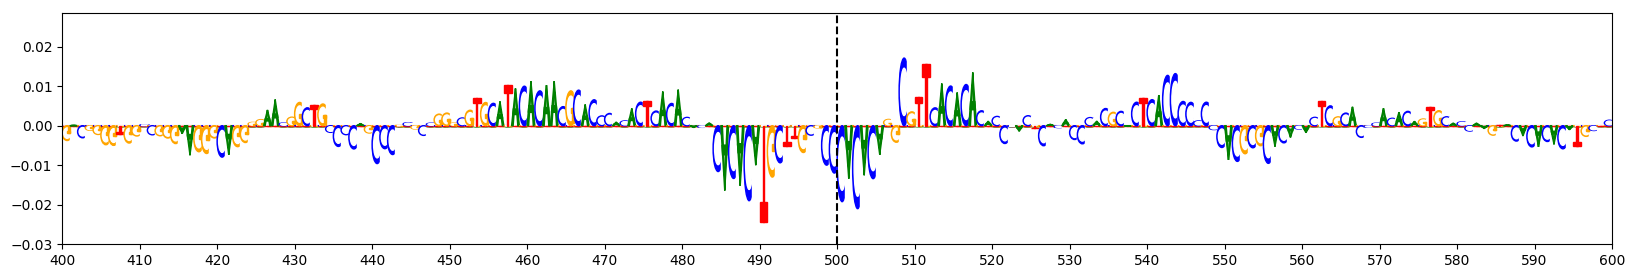

Index:  1  Delta:  -0.12705626350000002  RSID:  rs71475909
Minor - Major:  C - A


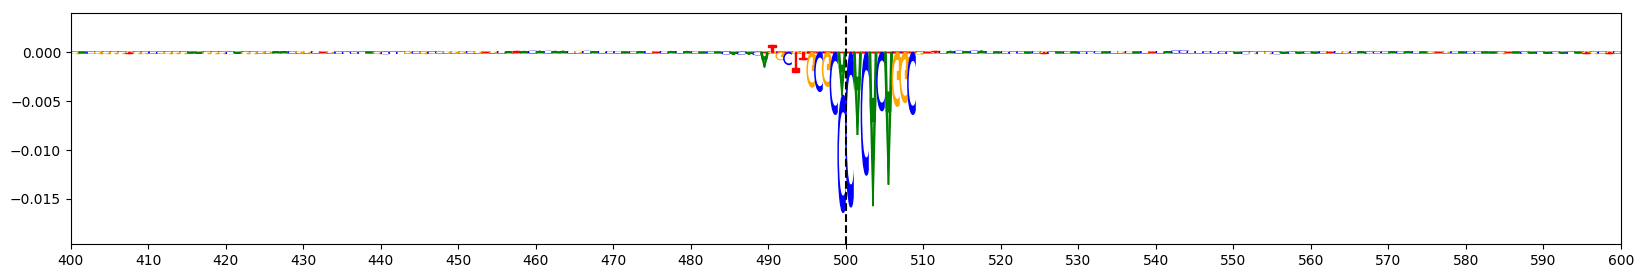

Index:  13  Importance:  0.8744558241  RSID:  rs567075   chr11 : 85830156 - 85830157  Locus:  150
Major Allele:  C


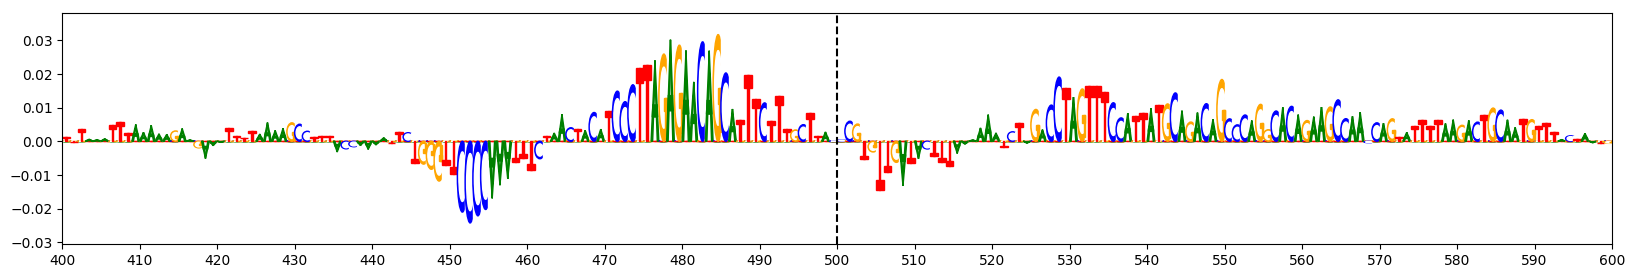

Index:  13  Importance:  0.829603332  RSID:  rs567075
Minor Allele:  T


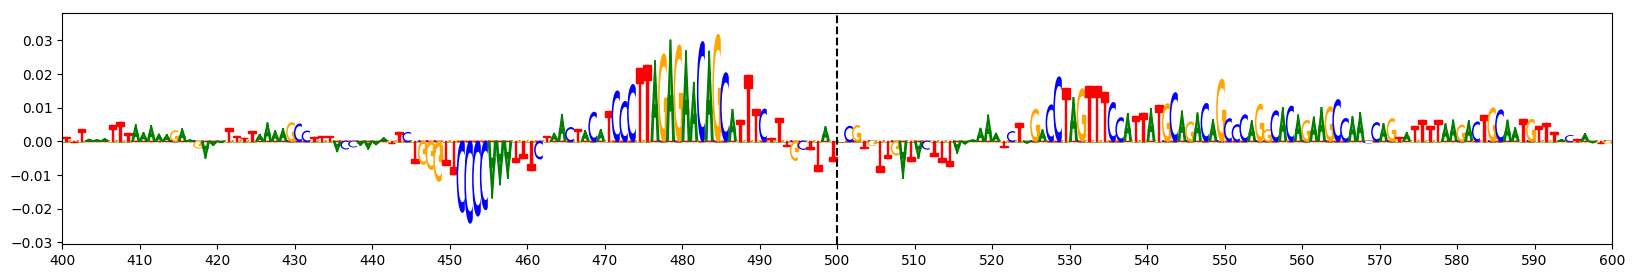

Index:  13  Delta:  -0.044852492099999974  RSID:  rs567075
Minor - Major:  T - C


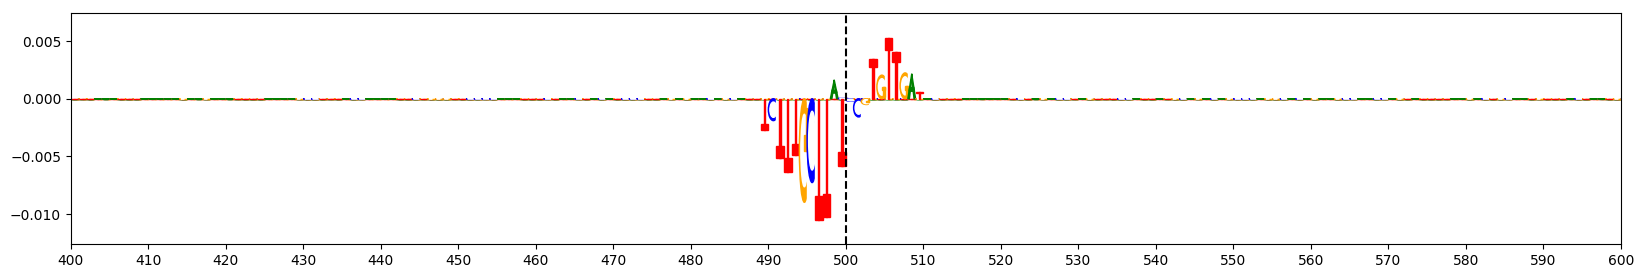

Index:  9  Importance:  0.6535255756  RSID:  rs2509608   chr11 : 85779296 - 85779297  Locus:  150
Major Allele:  G


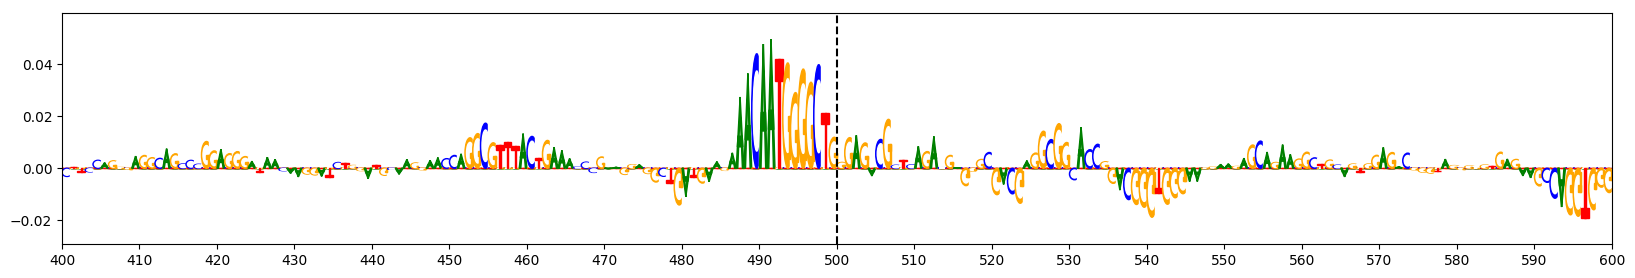

Index:  9  Importance:  0.6229255830999999  RSID:  rs2509608
Minor Allele:  T


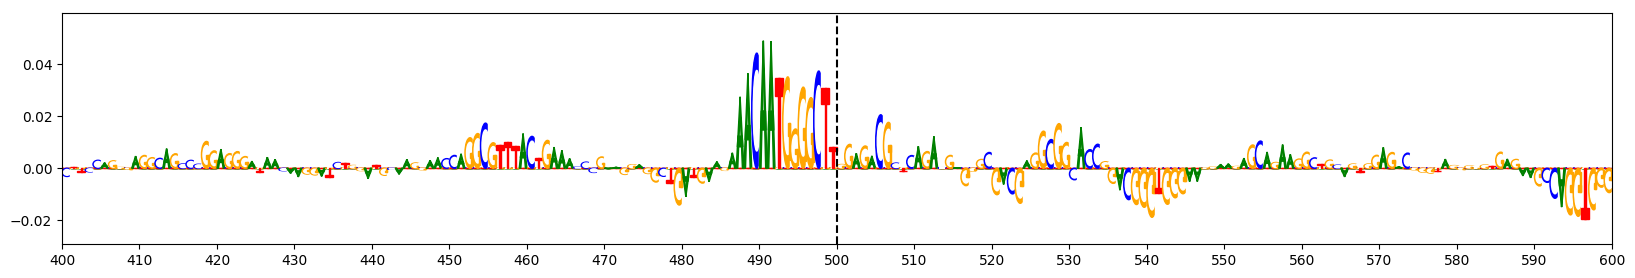

Index:  9  Delta:  -0.030599992500000117  RSID:  rs2509608
Minor - Major:  T - G


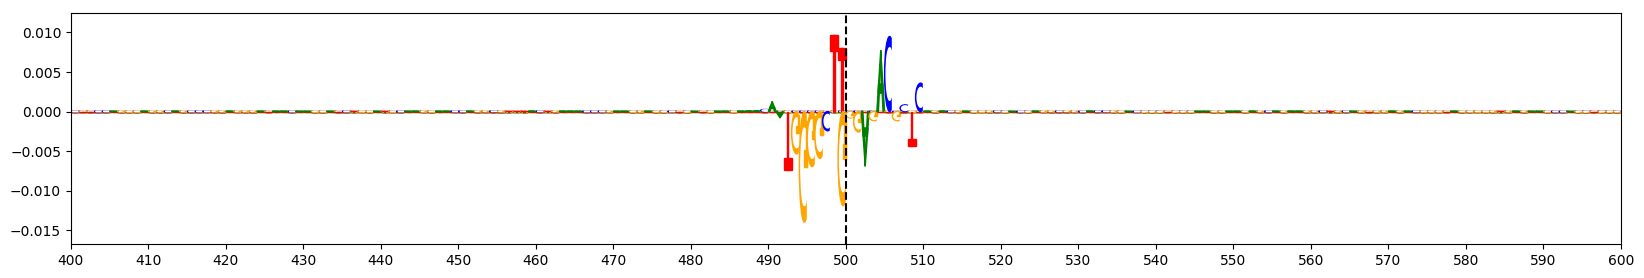

Index:  6  Importance:  0.16646115100000003  RSID:  rs11600581   chr11 : 47448496 - 47448497  Locus:  148
Major Allele:  T


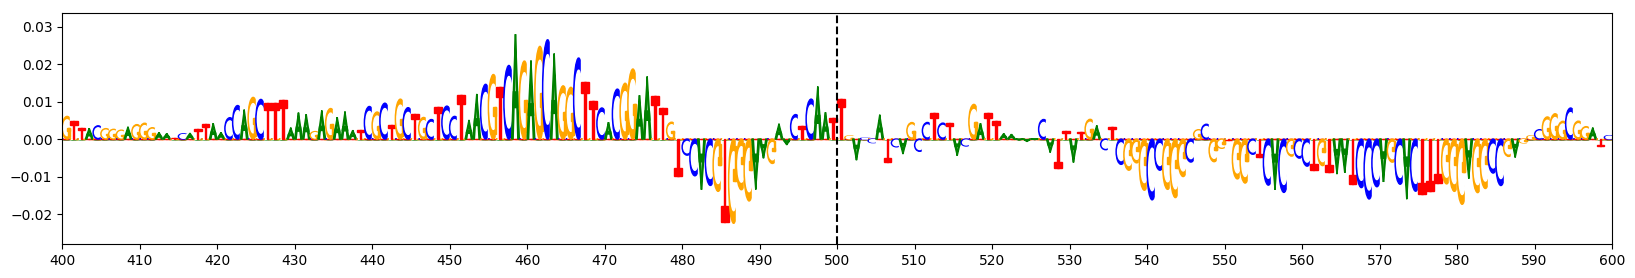

Index:  6  Importance:  0.1633386303  RSID:  rs11600581
Minor Allele:  A


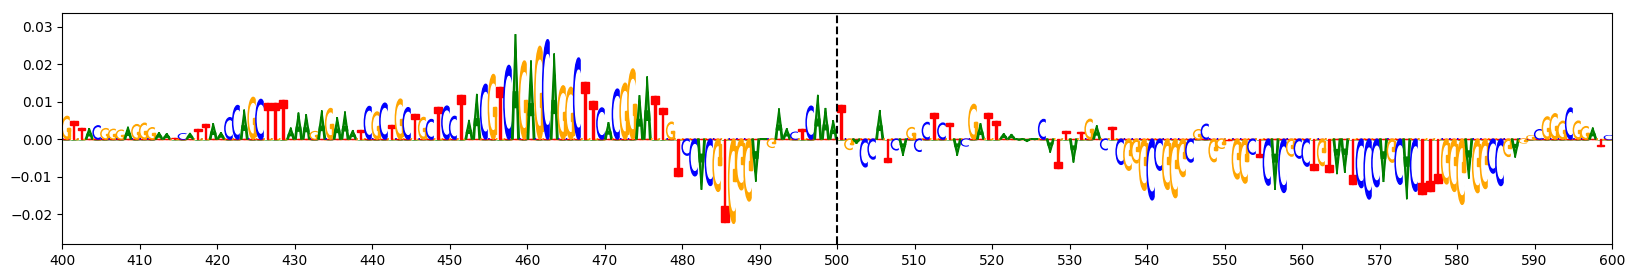

Index:  6  Delta:  -0.00312252070000002  RSID:  rs11600581
Minor - Major:  A - T


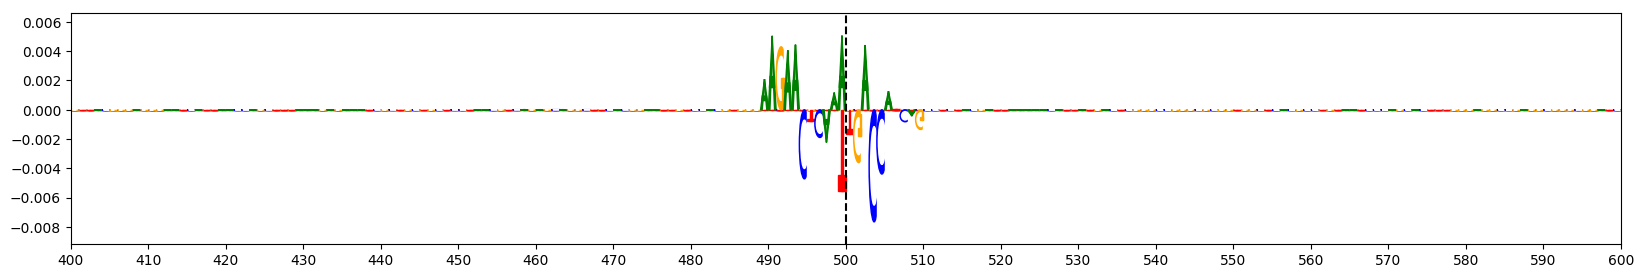

In [22]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx], 
          ' ', seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'], " Locus: ", seq_df.at[idx, 'locus'])
    print("Major Allele: ", gwas_major[idx])
    ylim = plot_weights(major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx])
    print("Minor Allele: ", gwas_minor[idx])
    a = plot_weights(minor_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

## Find Alternate Alleles that Improve Accessibility

In [23]:
seq_df.sort_values(by='delta', ascending=False, inplace=True)
seq_df.head(10)

index    chr     start       end        rsid  locus major_allele  \
12     12  chr11  85815029  85815030   rs1237999    150            A   
3       3  chr11  47377282  47377283  rs71475909    148            A   
8       8  chr11  60033370  60033371   rs7930318    149            T   
11     11  chr11  85779309  85779310   rs2458500    150            G   
2       2  chr11  47377282  47377283  rs71475909    148            A   
7       7  chr11  47448496  47448497  rs11600581    148            T   
4       4  chr11  47429903  47429904   rs7947450    148            G   
10     10  chr11  85779296  85779297   rs2509608    150            G   
5       5  chr11  47430457  47430458   rs7937331    148            C   
6       6  chr11  47448496  47448497  rs11600581    148            T   

   minor_allele  major_score  minor_score     delta  
12            G     0.985476     1.415472  0.429996  
3             T     0.082805     0.162001  0.079196  
8             C     0.455150     0.516572  0.061421  
11            A     0.461088     0.479388  0.018300  
2             G     0.082805     0.095905  0.013100  
7             C     0.166461     0.173844  0.007383  
4             A     2.181930     2.185450  0.003521  
10            C     0.653526     0.655411  0.001886  
5             T     0.303433     0.300390 -0.003043  
6             A     0.166461     0.163339 -0.003123

## Get 10 bp around SNP

In [24]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(minor_seqs[idx][490:510])
    print(minor_seqs[idx][490:500], '|', major_seqs[idx][500:510])

ATTATCTATGAGTCACCAAC
tgcttgcgcacacacaggcg
GTCAACTCCCAGCTCTGGTC
GACGCTCAGACGAGGGCGAC
tgcttgcgcacacacaggcg


## Visualize Top Sequences

Index:  12  Importance:  0.9854759418  RSID:  rs1237999 chr11 :  85815029  -  85815030  Locus:  150
Minor Allele:  G


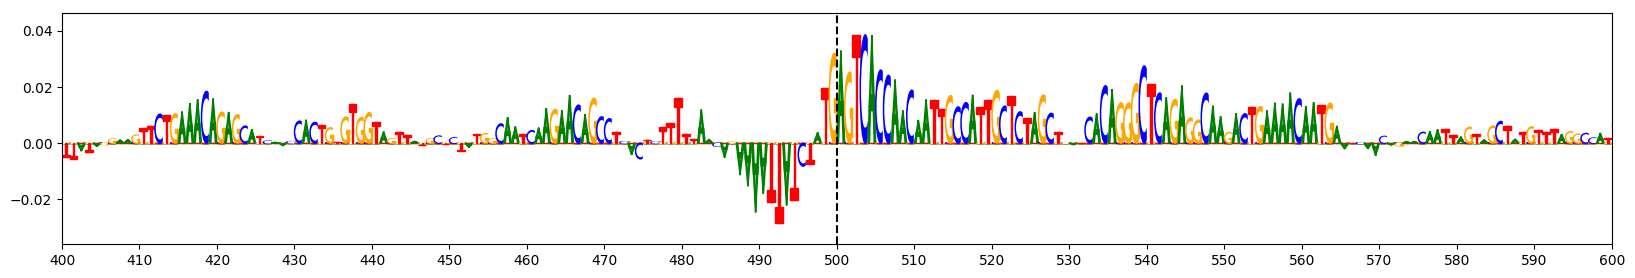

Index:  12  Importance:  0.9854759418  RSID:  rs1237999
Major Allele:  A


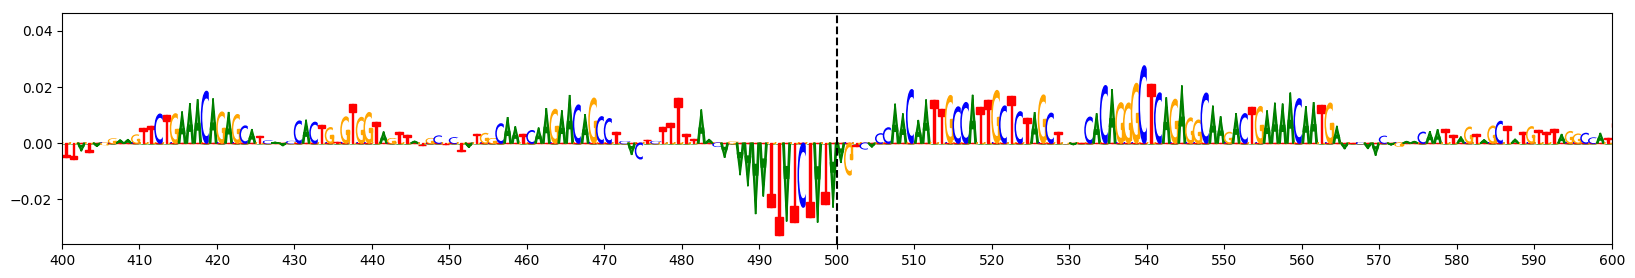

Index:  12  Delta:  0.4299957937000002  RSID:  rs1237999
Minor - Major:  G - A


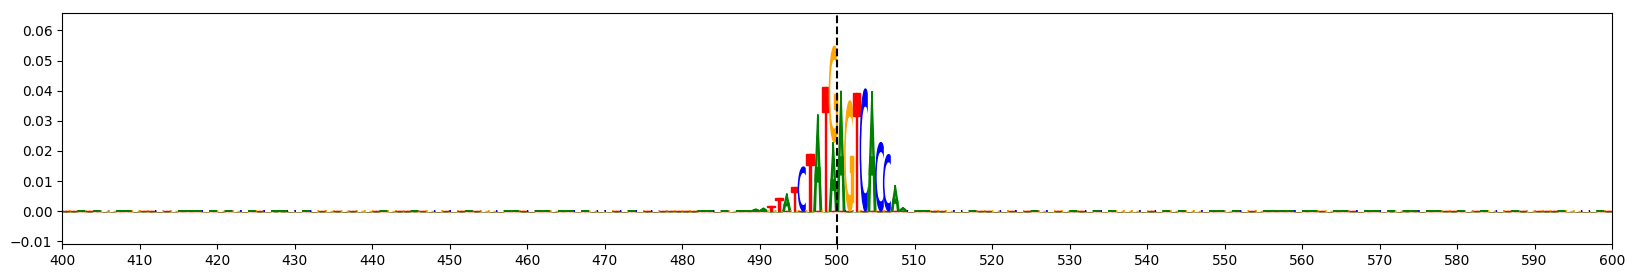

Index:  3  Importance:  0.0828051179  RSID:  rs71475909 chr11 :  47377282  -  47377283  Locus:  148
Minor Allele:  T


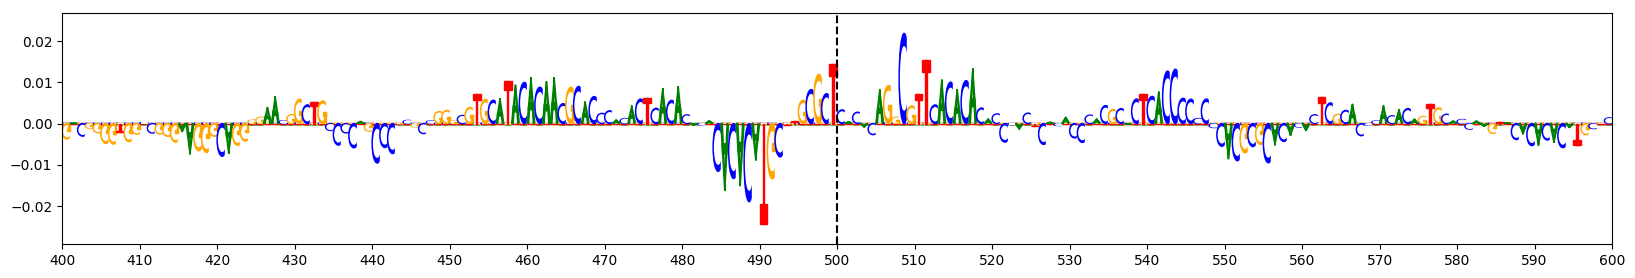

Index:  3  Importance:  0.0828051179  RSID:  rs71475909
Major Allele:  A


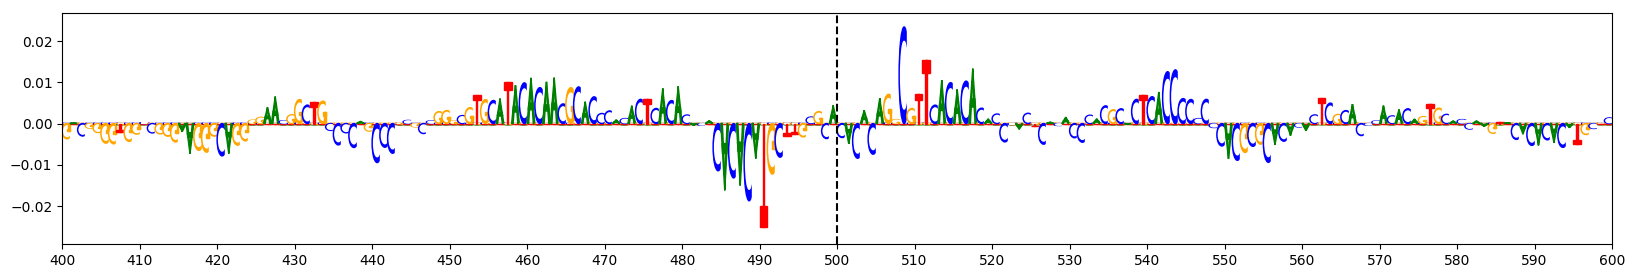

Index:  3  Delta:  0.07919567699999996  RSID:  rs71475909
Minor - Major:  T - A


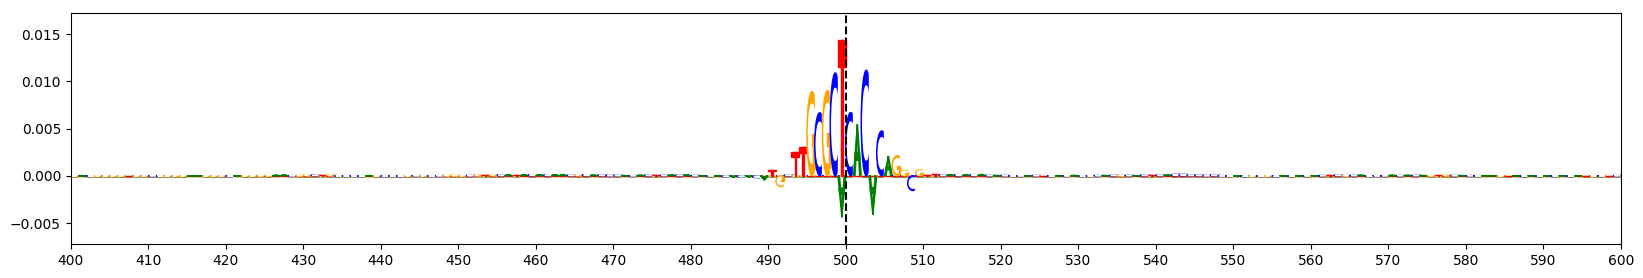

Index:  8  Importance:  0.45515026529999997  RSID:  rs7930318 chr11 :  60033370  -  60033371  Locus:  149
Minor Allele:  C


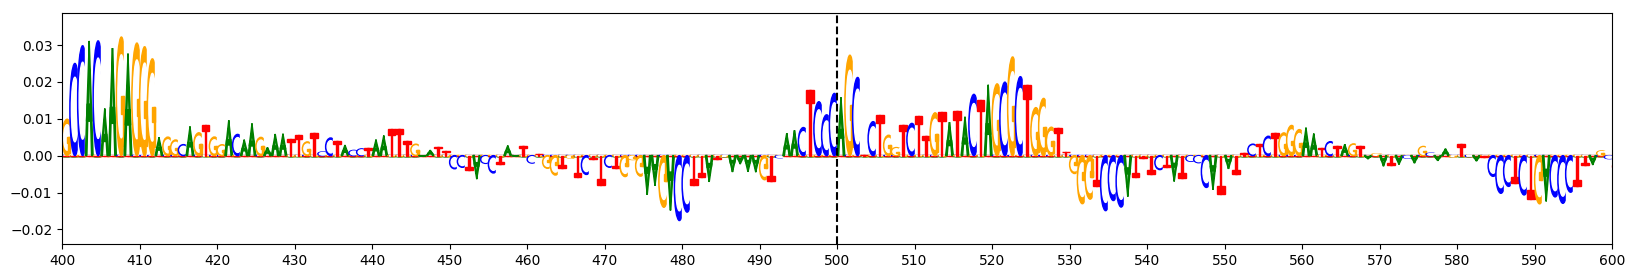

Index:  8  Importance:  0.45515026529999997  RSID:  rs7930318
Major Allele:  T


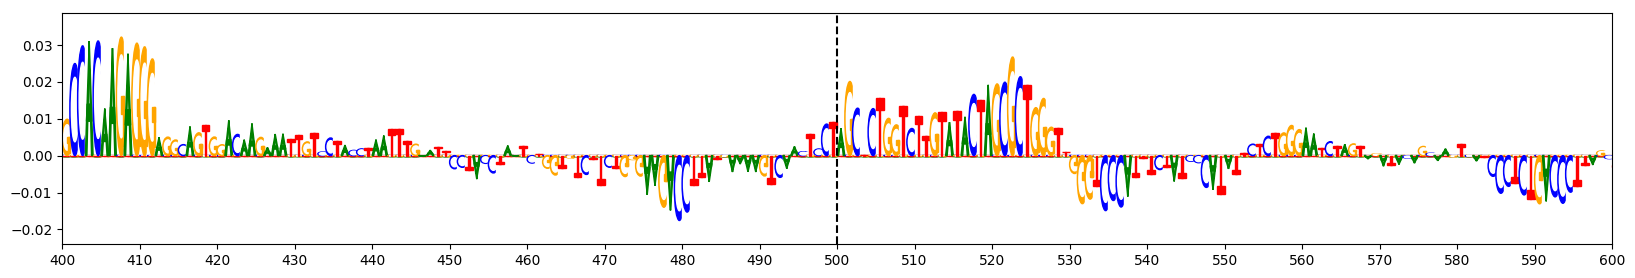

Index:  8  Delta:  0.06142145180000008  RSID:  rs7930318
Minor - Major:  C - T


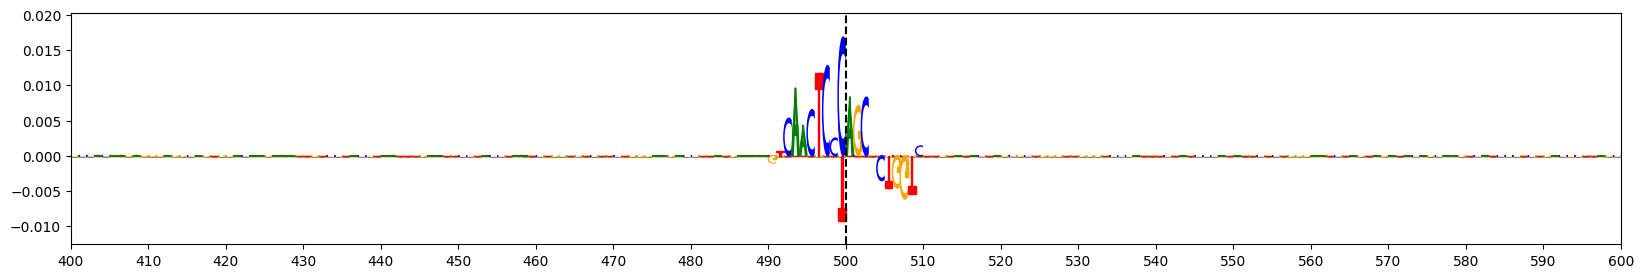

Index:  11  Importance:  0.4610880649999999  RSID:  rs2458500 chr11 :  85779309  -  85779310  Locus:  150
Minor Allele:  A


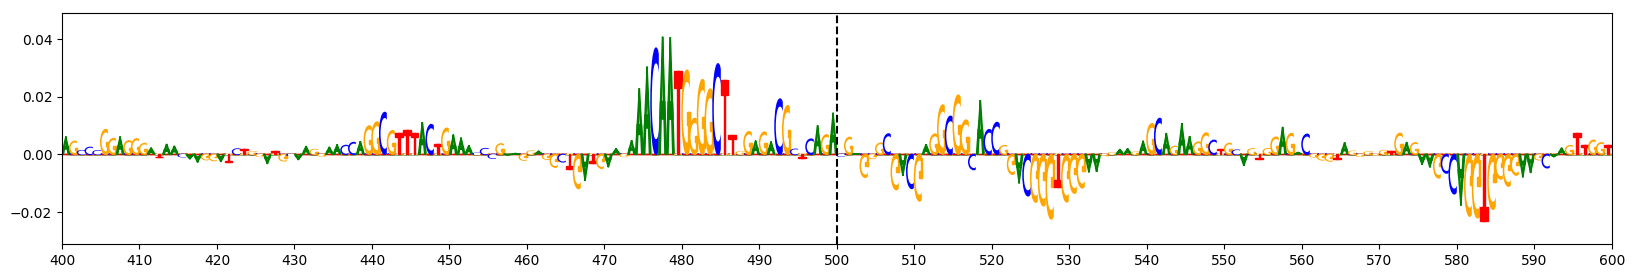

Index:  11  Importance:  0.4610880649999999  RSID:  rs2458500
Major Allele:  G


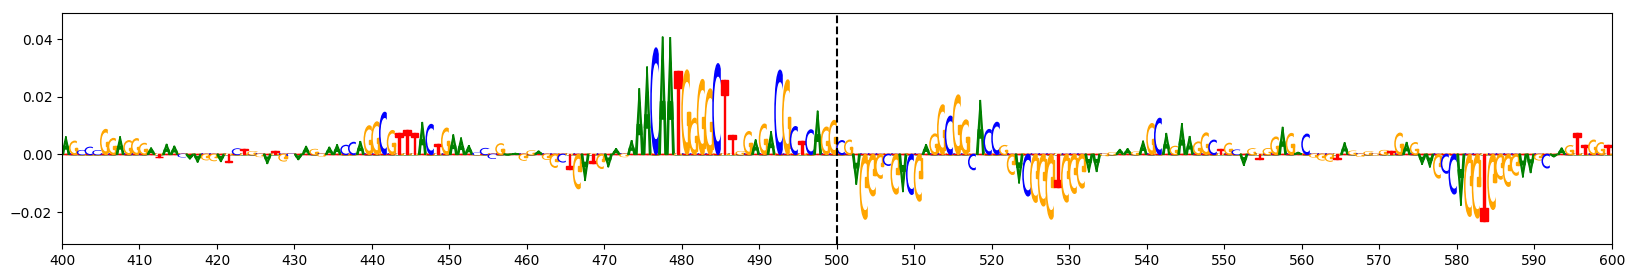

Index:  11  Delta:  0.018299632000000177  RSID:  rs2458500
Minor - Major:  A - G


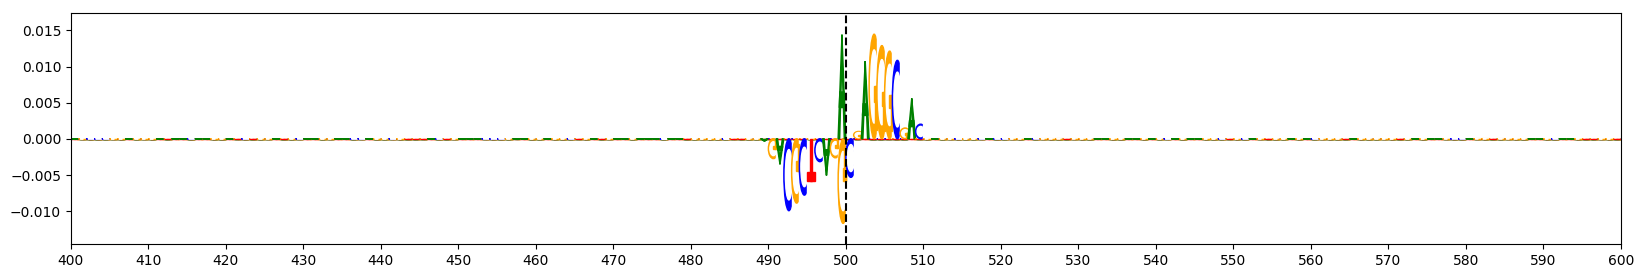

Index:  2  Importance:  0.0828051179  RSID:  rs71475909 chr11 :  47377282  -  47377283  Locus:  148
Minor Allele:  G


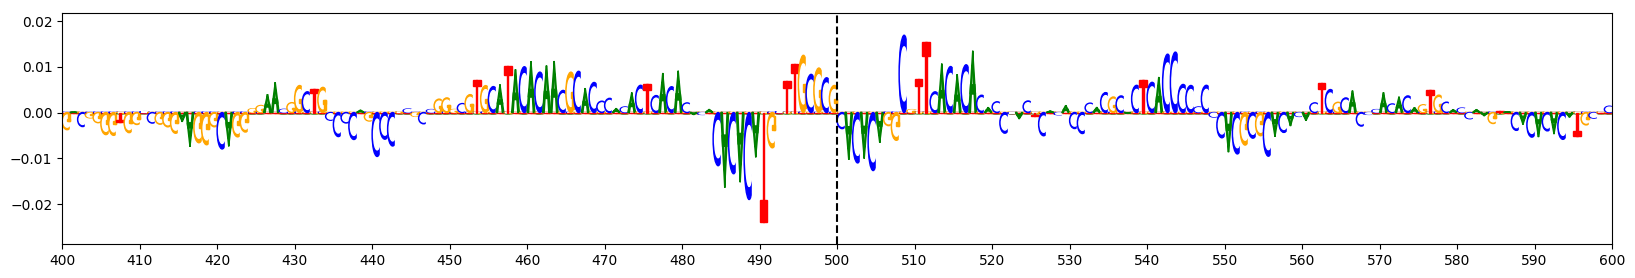

Index:  2  Importance:  0.0828051179  RSID:  rs71475909
Major Allele:  A


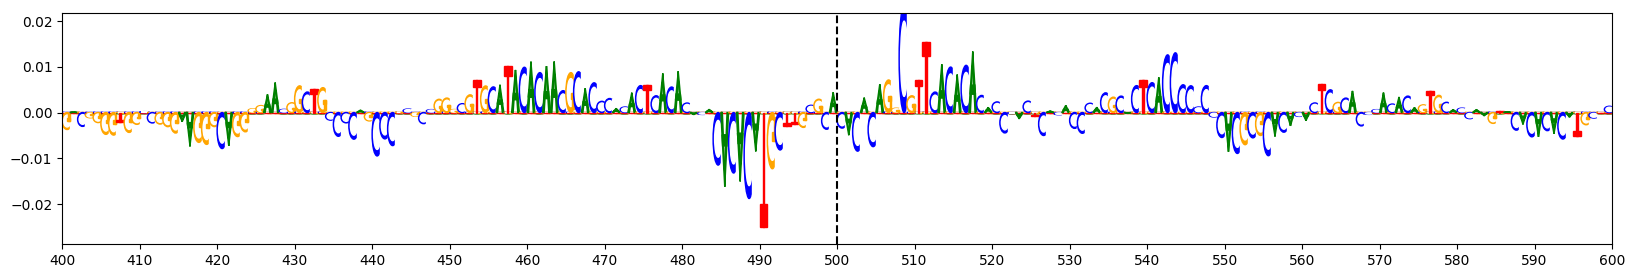

Index:  2  Delta:  0.013100219900000001  RSID:  rs71475909
Minor - Major:  G - A


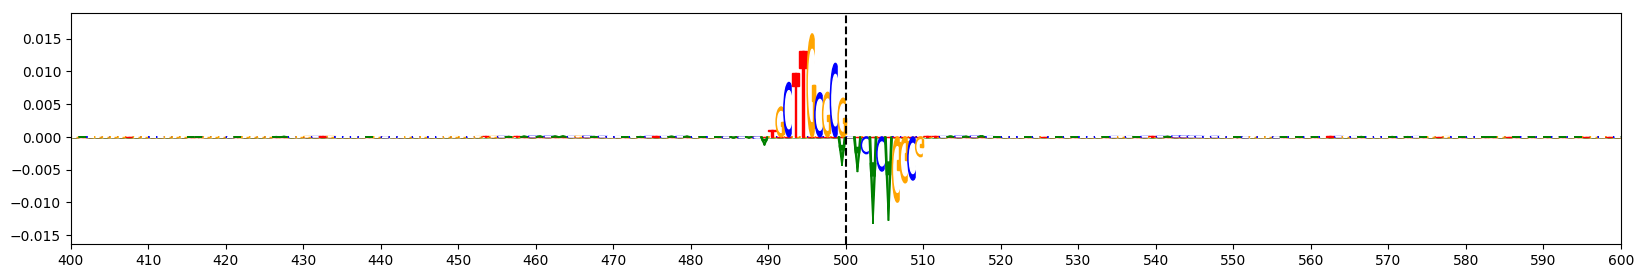

In [25]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx], 
          seq_df.at[idx, 'chr'], ': ', seq_df.at[idx, 'start'], ' - ', seq_df.at[idx, 'end'], " Locus: ", seq_df.at[idx, 'locus'])
    print("Minor Allele: ", gwas_minor[idx])
    ylim = plot_weights(minor_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx])
    print("Major Allele: ", gwas_major[idx])
    a = plot_weights(major_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

# Fold 9

## Prepare Reference Alleles

In [26]:
cluster = '13'
fold = '9'
peak = 'overlap'
gwas = 'Kunkle'
gwas_bed = pd.read_csv('/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.txt', header=None, sep='\t')
gwas_chrom = gwas_bed[0].tolist()
gwas_start = gwas_bed[1].tolist()
gwas_end = gwas_bed[2].tolist()
gwas_rsid = gwas_bed[3].tolist()
gwas_locus = gwas_bed[5].to_list()
gwas_major = gwas_bed[6].tolist()
gwas_minor = gwas_bed[7].tolist()

major_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.major.fasta'
major_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_major_hyp_scores.txt'

major_seqs = [x.rstrip() for (i,x) in enumerate(open(major_fasta)) if i%2==1]
major_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in major_seqs if ('N' not in x)]

print("Num onehot sequences:", len(major_onehot))

major_hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(major_hyp_file)], major_seqs) if 'N' not in w[1]]

major_imp_scores = get_impscores(major_hyp_scores, major_onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(major_imp_scores,
                                 major_onehot,
                                 major_hyp_scores)])) == 0

major_normed_imp_scores, major_normed_hyp_scores = normalize_scores(
    impscores=major_imp_scores, hyp_impscores=major_hyp_scores, onehot_data=major_onehot)

Num onehot sequences: 3


## Prepare Alternate Alleles

In [27]:
minor_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.minor.fasta'
minor_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_minor_hyp_scores.txt'
                                                                                
minor_seqs = [x.rstrip() for (i,x) in enumerate(open(minor_fasta)) if i%2==1]       
minor_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in minor_seqs if ('N' not in x)]
                                                                                
print("Num onehot sequences:", len(minor_onehot))                                 
                                                                                
minor_hyp_scores = [w[0] for w in zip([                                           
    np.array([[float(z) for z in y.split(",")]                                  
                for y in x.rstrip().split("\t")[2].split(";")])                 
    for x in open(minor_hyp_file)], minor_seqs) if 'N' not in w[1]]                 
                                                                                
minor_imp_scores = get_impscores(minor_hyp_scores, minor_onehot)                      
                                                                                
assert (np.max([np.max(np.abs(z*y - x))                                         
                for x,y,z in zip(minor_imp_scores,                                
                                 minor_onehot,                                    
                                 minor_hyp_scores)])) == 0                        
                                                                                
minor_normed_imp_scores, minor_normed_hyp_scores = normalize_scores(                
    impscores=minor_imp_scores, hyp_impscores=minor_hyp_scores, onehot_data=minor_onehot)

Num onehot sequences: 3


## Find Alternate Alleles that Break Accessibility

In [28]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'rsid': [], 'locus':[], 'major_allele':[], 'minor_allele':[], 'major_score':[], 'minor_score':[], 'delta':[]}

for i,j in enumerate(gwas_chrom):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(gwas_chrom[i])
    seq_dict['start'].append(gwas_start[i])
    seq_dict['end'].append(gwas_end[i])
    seq_dict['rsid'].append(gwas_rsid[i])
    seq_dict['locus'].append(gwas_locus[i])
    seq_dict['major_allele'].append(gwas_major[i])
    seq_dict['minor_allele'].append(gwas_minor[i])
    seq_dict['major_score'].append(np.sum(major_imp_scores[i][400:600]))
    seq_dict['minor_score'].append(np.sum(minor_imp_scores[i][400:600]))
    seq_dict['delta'].append(np.sum(minor_imp_scores[i][400:600]) - np.sum(major_imp_scores[i][400:600]))
    
seq_df = pd.DataFrame.from_dict(seq_dict)
seq_df.sort_values(by='delta', ascending=True, inplace=True)
seq_df.head(10)

index   chr     start       end       rsid  locus major_allele  \
1      1  chr8  27466180  27466181  rs1532277    161            C   
0      0  chr8  27466156  27466157  rs1532276    161            C   
2      2  chr8  27466314  27466315  rs1532278    161            C   

  minor_allele  major_score  minor_score     delta  
1            T     0.579975     0.515495 -0.064480  
0            T     0.307420     0.383752  0.076332  
2            T     1.336026     1.493247  0.157221

## Get 10 bp around SNP

In [29]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(major_seqs[idx][490:510])
    print(major_seqs[idx][490:500], '|', major_seqs[idx][500:510])

gaactagcatgtgatcaggg
gccaccccatccagagcctg
GCTTCTTAATTGCAGCCTCA


## Visualize Top Sequences

Index:  1  Importance:  0.57997495832  RSID:  rs1532277   chr8 : 27466180 - 27466181  Locus:  161
Major Allele:  C


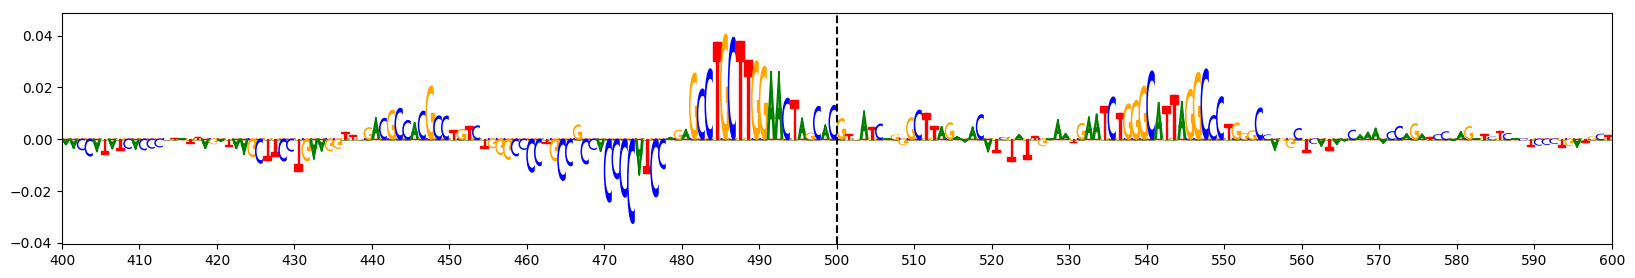

Index:  1  Importance:  0.51549488454  RSID:  rs1532277
Minor Allele:  T


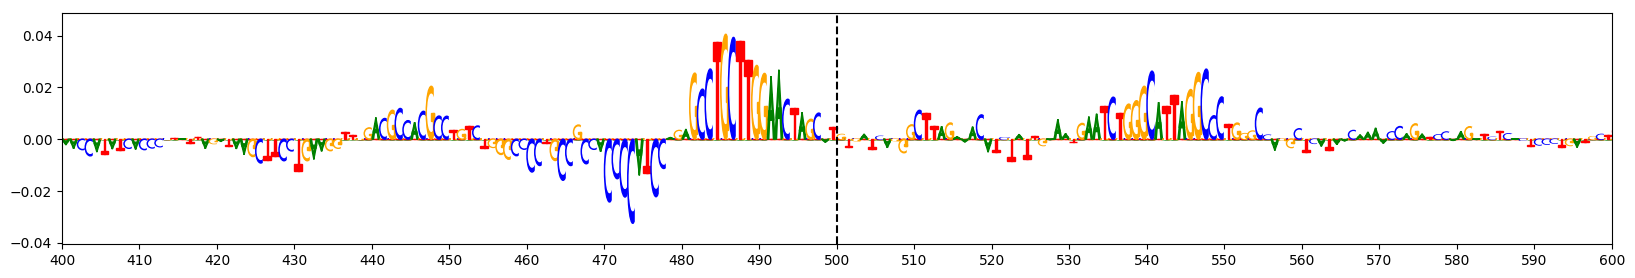

Index:  1  Delta:  -0.06448007377999998  RSID:  rs1532277
Minor - Major:  T - C


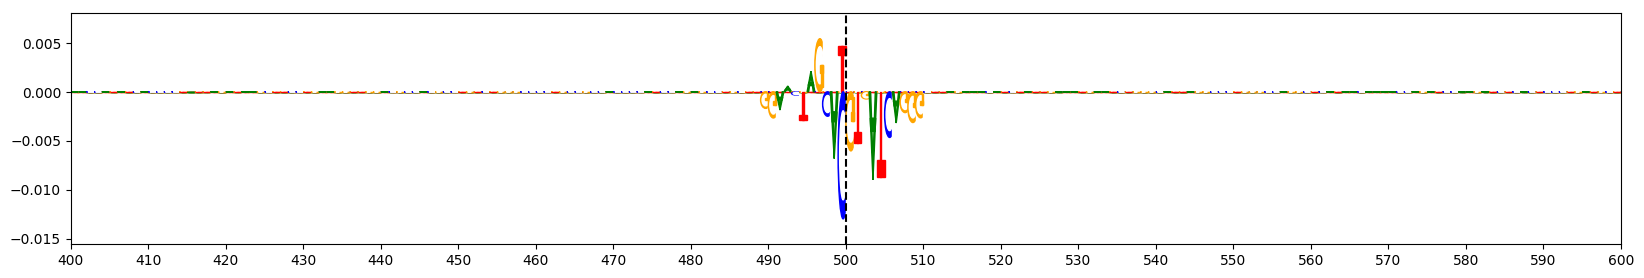

Index:  0  Importance:  0.3074199905000001  RSID:  rs1532276   chr8 : 27466156 - 27466157  Locus:  161
Major Allele:  C


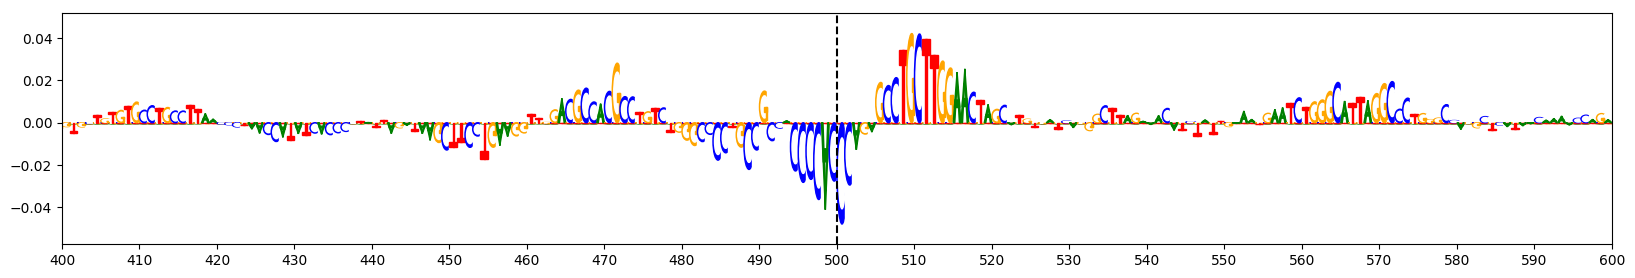

Index:  0  Importance:  0.38375221380000013  RSID:  rs1532276
Minor Allele:  T


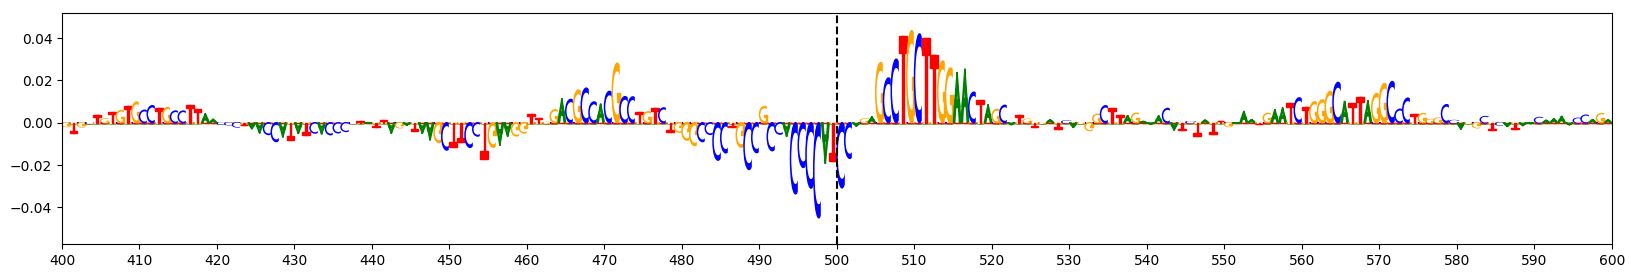

Index:  0  Delta:  0.07633222330000006  RSID:  rs1532276
Minor - Major:  T - C


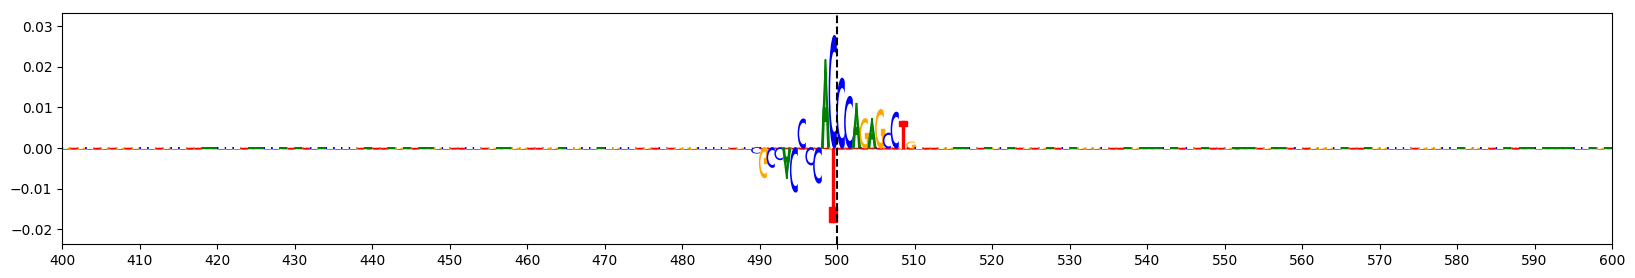

Index:  2  Importance:  1.3360260913000002  RSID:  rs1532278   chr8 : 27466314 - 27466315  Locus:  161
Major Allele:  C


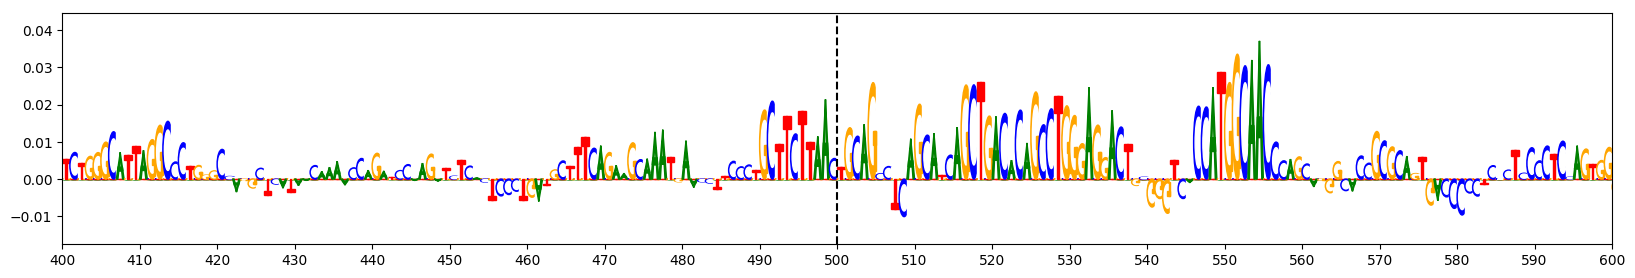

Index:  2  Importance:  1.4932465963000001  RSID:  rs1532278
Minor Allele:  T


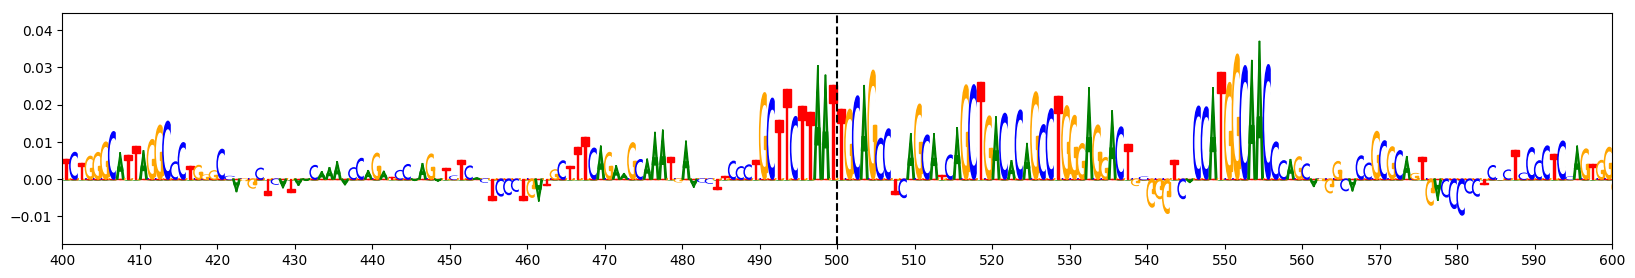

Index:  2  Delta:  0.15722050499999995  RSID:  rs1532278
Minor - Major:  T - C


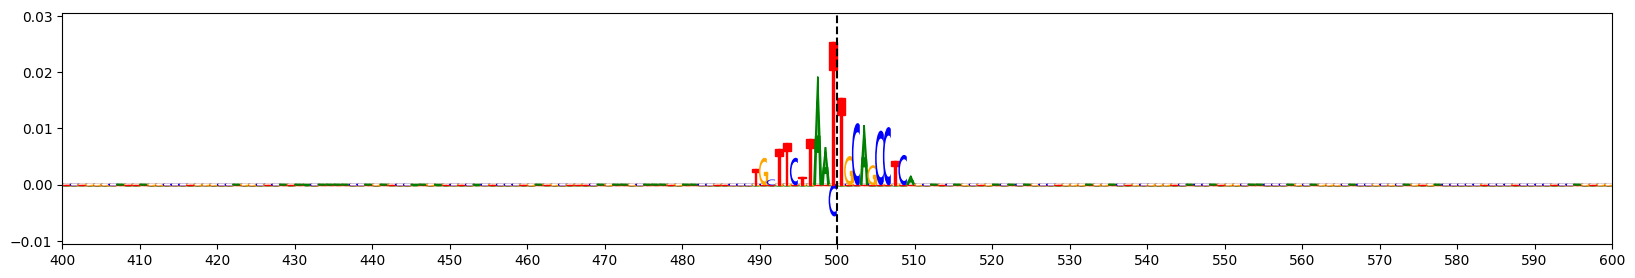

In [30]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx], 
          ' ', seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'], " Locus: ", seq_df.at[idx, 'locus'])
    print("Major Allele: ", gwas_major[idx])
    ylim = plot_weights(major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx])
    print("Minor Allele: ", gwas_minor[idx])
    a = plot_weights(minor_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

## Find Alternate Alleles that Improve Accessibility

In [31]:
seq_df.sort_values(by='delta', ascending=False, inplace=True)
seq_df.head(10)

index   chr     start       end       rsid  locus major_allele  \
2      2  chr8  27466314  27466315  rs1532278    161            C   
0      0  chr8  27466156  27466157  rs1532276    161            C   
1      1  chr8  27466180  27466181  rs1532277    161            C   

  minor_allele  major_score  minor_score     delta  
2            T     1.336026     1.493247  0.157221  
0            T     0.307420     0.383752  0.076332  
1            T     0.579975     0.515495 -0.064480

## Get 10 bp around SNP

In [32]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(minor_seqs[idx][490:510])
    print(minor_seqs[idx][490:500], '|', major_seqs[idx][500:510])

GCTTCTTAATTGCAGCCTCA
gccaccccatccagagcctg
gaactagcatgtgatcaggg


## Visualize Top Sequences

Index:  2  Importance:  1.3360260913000002  RSID:  rs1532278 chr8 :  27466314  -  27466315  Locus:  161
Minor Allele:  T


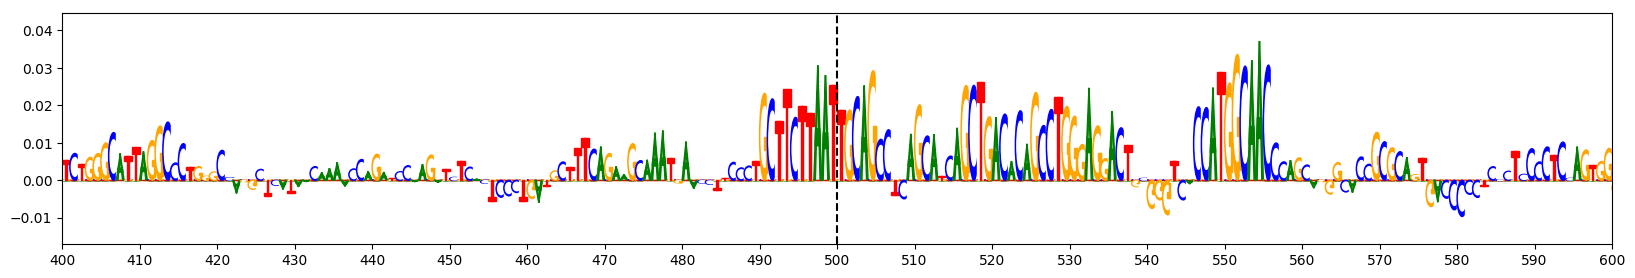

Index:  2  Importance:  1.3360260913000002  RSID:  rs1532278
Major Allele:  C


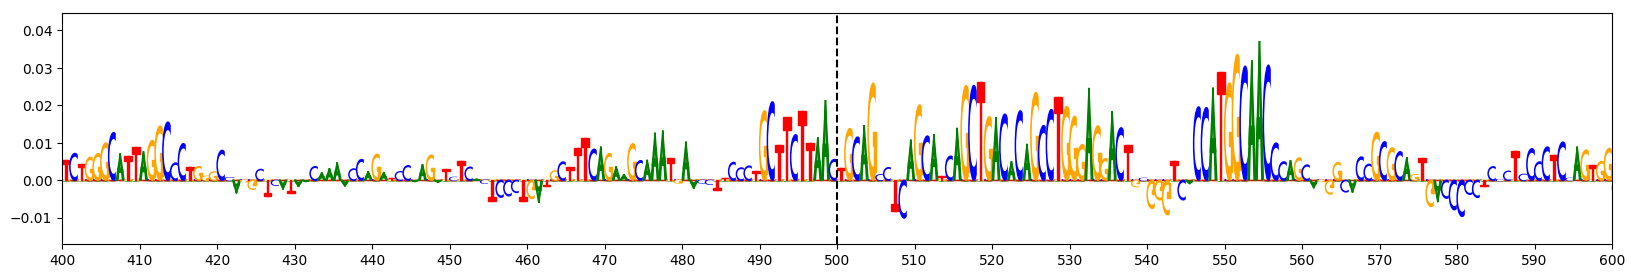

Index:  2  Delta:  0.15722050499999995  RSID:  rs1532278
Minor - Major:  T - C


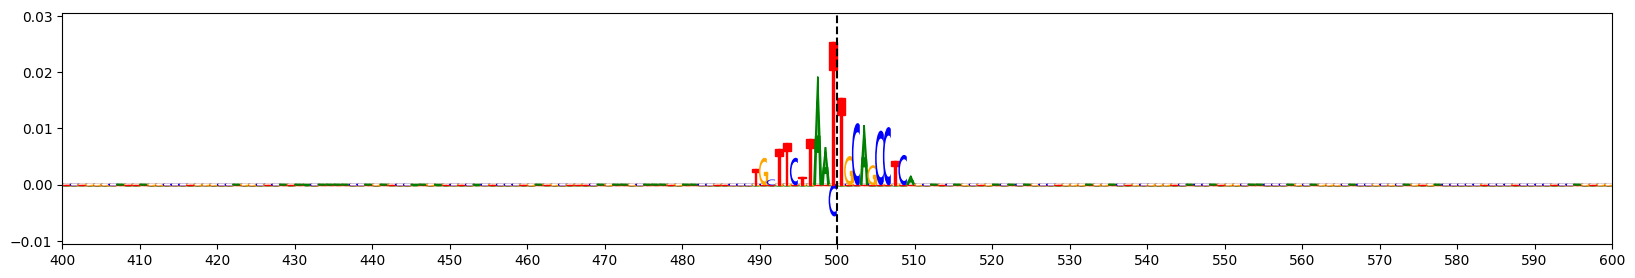

Index:  0  Importance:  0.3074199905000001  RSID:  rs1532276 chr8 :  27466156  -  27466157  Locus:  161
Minor Allele:  T


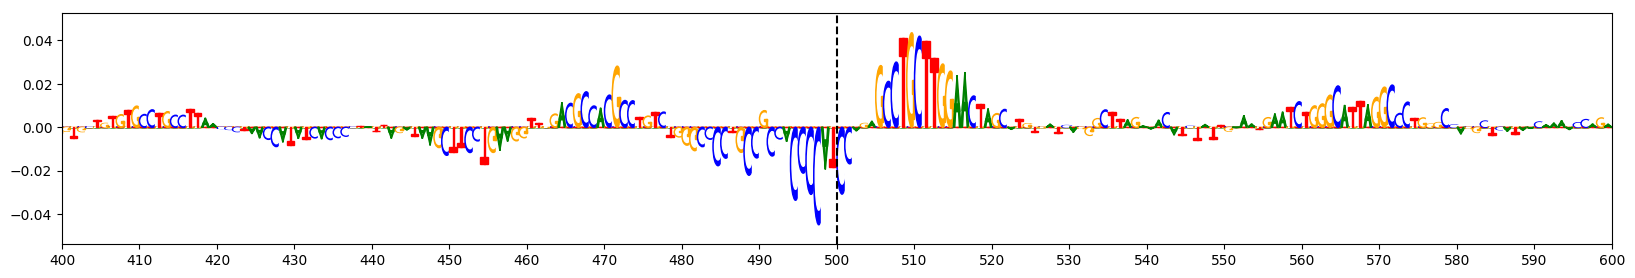

Index:  0  Importance:  0.3074199905000001  RSID:  rs1532276
Major Allele:  C


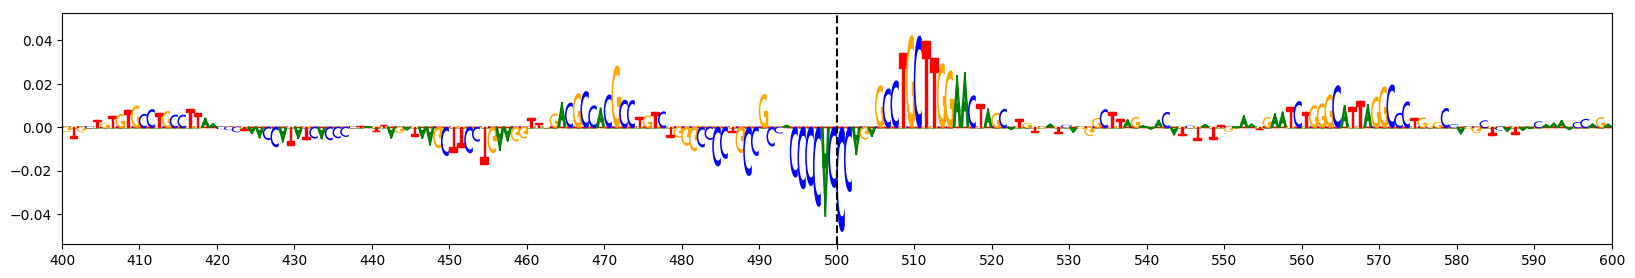

Index:  0  Delta:  0.07633222330000006  RSID:  rs1532276
Minor - Major:  T - C


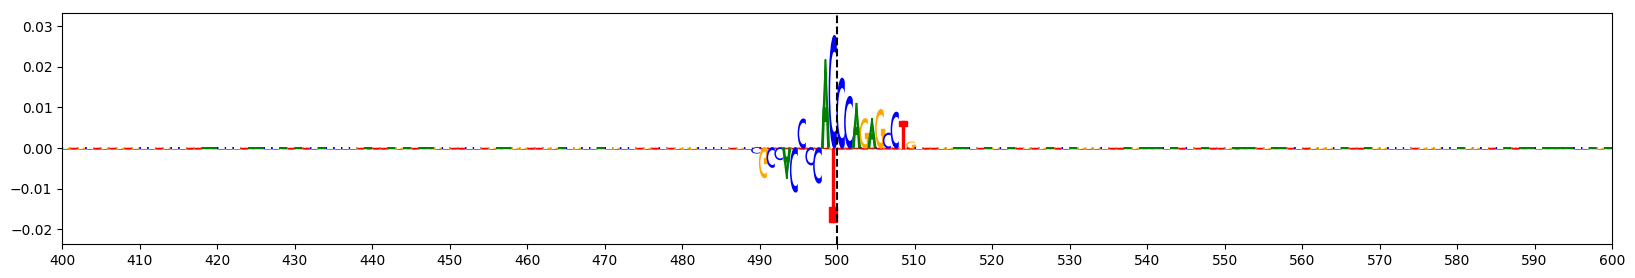

Index:  1  Importance:  0.57997495832  RSID:  rs1532277 chr8 :  27466180  -  27466181  Locus:  161
Minor Allele:  T


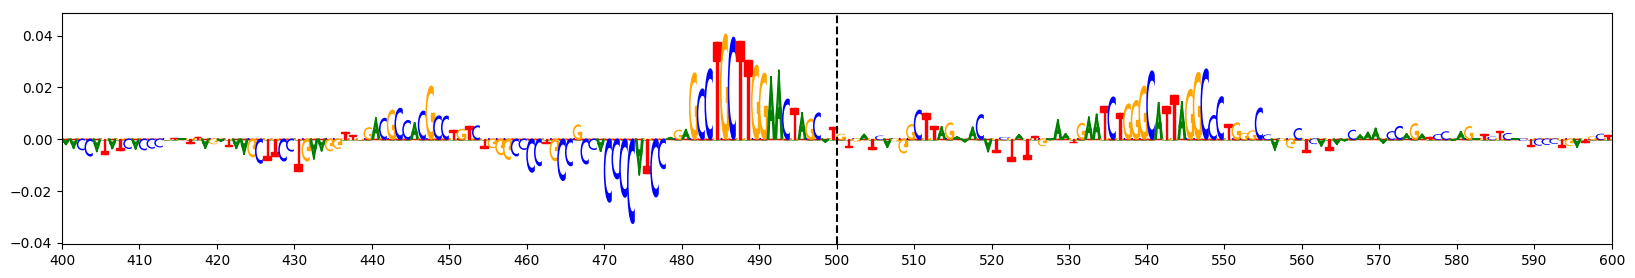

Index:  1  Importance:  0.57997495832  RSID:  rs1532277
Major Allele:  C


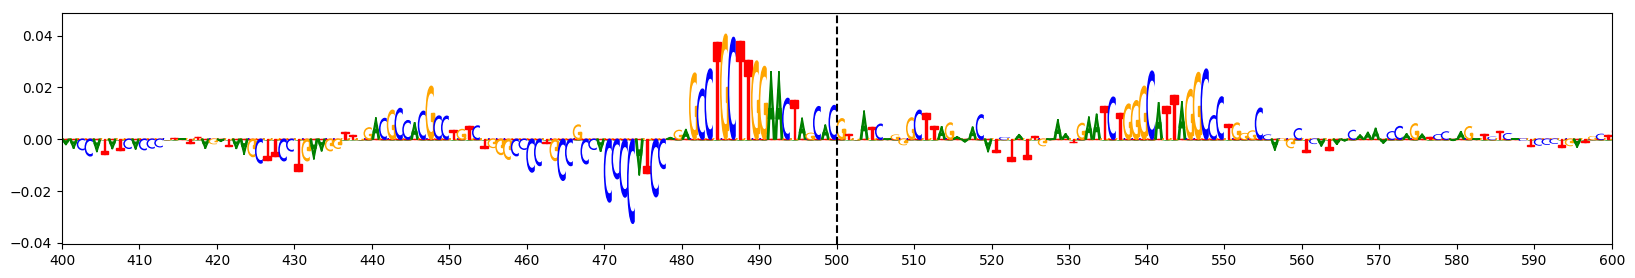

Index:  1  Delta:  -0.06448007377999998  RSID:  rs1532277
Minor - Major:  T - C


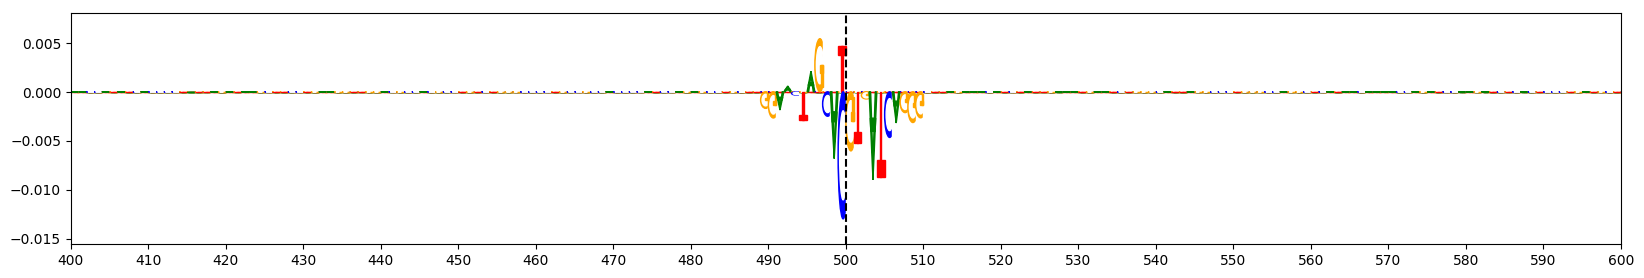

In [33]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx], 
          seq_df.at[idx, 'chr'], ': ', seq_df.at[idx, 'start'], ' - ', seq_df.at[idx, 'end'], " Locus: ", seq_df.at[idx, 'locus'])
    print("Minor Allele: ", gwas_minor[idx])
    ylim = plot_weights(minor_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx])
    print("Major Allele: ", gwas_major[idx])
    a = plot_weights(major_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))